# Homework 3 - Attacks and Defenses in Federated Learning

## infrastructure

Based on a variant of FedAvg that updates parameter differences rather than a complete.
As regular FedAvg, this variant performs multiple local epochs.
Unlike regular FedAvg, clients now determine the deviation of their local parameters from the servers' parameters and upload the differences to the server.
Perhaps surprisingly, these differences are referred to as "gradients".

This variant is pretty much equivalent to the original one but makes it easier to reason about updates.

In [1]:
# Also includes all the dependencies of this module, as the dependencies are members of that module
import typing

from fedavg import *
from matplotlib import pyplot as plt

if torch.accelerator.is_available():
    device = torch.accelerator.current_accelerator()
    print(f"Using accelerator '{device}'")
else:
    device = torch.device("cpu")
    print("WARN: No accelerator found, running on CPU")

Using accelerator 'mps'
Using accelerator 'mps'


In [2]:
class GradWeightClient(Client):
    def __init__(
        self, client_data: Subset, lr: float, batch_size: int, nr_epochs: int
    ) -> None:
        super().__init__(client_data, batch_size)
        self.optimizer = SGD(params=self.model.parameters(), lr=lr)
        self.nr_epochs = nr_epochs

    def update(self, weights: list[torch.Tensor], seed: int) -> list[torch.Tensor]:
        # Load the server weights into the model
        with torch.no_grad():
            for client_values, server_values in zip(self.model.parameters(), weights):
                client_values[:] = server_values

        torch.manual_seed(seed)

        # Save initial weights to calculate the gradients later
        initial_weights = [param.clone() for param in self.model.parameters()]

        for _epoch in range(self.nr_epochs):
            train_epoch(self.model, self.loader_train, self.optimizer)

        # Calculate gradients: initial_weights - final_weights
        gradients = [
            initial_weight - final_weight
            for final_weight, initial_weight in zip(
                self.model.parameters(), initial_weights
            )
        ]
        return [gradient.detach().cpu().clone() for gradient in gradients]


class FedAvgGradServer(DecentralizedServer, ABC):
    def __init__(
        self,
        lr: float,
        batch_size: int,
        client_subsets: list[Subset],
        client_fraction: float,
        nr_local_epochs: int,
        seed: int,
    ) -> None:
        super().__init__(lr, batch_size, client_subsets, client_fraction, seed)
        self.name = "FedAvg"
        self.nr_local_epochs = nr_local_epochs
        self.clients = [
            GradWeightClient(subset, lr, batch_size, nr_local_epochs)
            for subset in client_subsets
        ]


def is_client_benign(client: Client) -> bool:
    # benign clients are instances of 'GradWeightClient', malicious clients are subtypes
    return type(client) == GradWeightClient

In [3]:
type SplitDataset = typing.Sequence[torch.utils.data.Dataset[typing.Any]]

### attacks

In [4]:
class AttackerGradientReversion(GradWeightClient):
    def update(self, weights: list[torch.Tensor], seed: int) -> list[torch.Tensor]:
        # Call the base implementation to perform the normal training and update process
        honest_gradients = super().update(weights, seed)

        # Reverse the gradients: for a malicious client, negate the weights to simulate an attack
        reversed_gradients = [-5*w for w in honest_gradients]
    

        return reversed_gradients

def build_gradient_reversion_client(
    client_data: torch.utils.data.Dataset[typing.Any],
    learning_rate: float,
    batch_size: int,
    epochs: int,
):
    return AttackerGradientReversion(client_data, learning_rate, batch_size, epochs)

In [5]:
class AttackerPartGradientReversion(GradWeightClient):
    def update(self, weights: list[torch.Tensor], seed: int) -> list[torch.Tensor]:
        # Set random seed for reproducibility
        torch.manual_seed(seed)

        # Call the base implementation to perform the normal training and update process
        honest_gradients = super().update(weights, seed)

        # Flatten the gradients and calculate 10% of the total number of gradient elements
        all_gradients = torch.cat([g.flatten() for g in honest_gradients])
        num_to_manipulate = int(all_gradients.numel())

        # Determine the threshold of parameters to modify
        param_threshold = (
            num_to_manipulate * 0.00001
        )  # Set this to your desired threshold

        # Select the first k layers until the cumulative number of parameters exceeds the threshold
        cumulative_params = 0
        selected_gradients = []
        for gradient in honest_gradients:
            # print(gradient.numel())
            cumulative_params += gradient.numel()
            selected_gradients.append(gradient)
            if cumulative_params >= param_threshold:
                break

        # Multiply the selected gradients by -1000
        for gradient in selected_gradients:
            gradient *= -1000

        return honest_gradients  # Return the modified gradients


def build_partial_gradient_reversion_client(
    client_data: torch.utils.data.Dataset[typing.Any],
    learning_rate: float,
    batch_size: int,
    epochs: int,
):
    return AttackerPartGradientReversion(client_data, learning_rate, batch_size, epochs)

In [6]:
# a new data class that help us to process batch
@dataclass
class Batch:
    batch_id: int
    inputs: torch.Tensor
    labels: torch.Tensor

    def __post_init__(self):
        self.batch_size = self.inputs.shape[0]

    def to(self, device):
        inputs = self.inputs.to(device)
        labels = self.labels.to(device)
        return Batch(self.batch_id, inputs, labels)

    def clone(self):
        inputs = self.inputs.clone()
        labels = self.labels.clone()
        return Batch(self.batch_id, inputs, labels)

    def clip(self, batch_size):
        if batch_size is None:
            return self

        inputs = self.inputs[:batch_size]
        labels = self.labels[:batch_size]

        return Batch(self.batch_id, inputs, labels)


class Synthesizer:
    def __init__(self, poisoning_proportion):
        self.poisoning_proportion = poisoning_proportion

    def make_backdoor_batch(self, batch: Batch, test=False, attack=True) -> Batch:
        if not attack:
            return batch

        if test:
            attack_portion = batch.batch_size
        else:
            attack_portion = round(batch.batch_size * self.poisoning_proportion)

        backdoored_batch = batch.clone()
        self.apply_backdoor(backdoored_batch, attack_portion)
        return backdoored_batch

    def apply_backdoor(self, batch, attack_portion):
        """
        Modifies only a portion of the batch (represents batch poisoning).

        :param batch:
        :return:
        """
        self.synthesize_inputs(batch=batch, attack_portion=attack_portion)
        self.synthesize_labels(batch=batch, attack_portion=attack_portion)

        return

    def synthesize_inputs(self, batch, attack_portion=None) -> None:
        raise NotImplemented

    def synthesize_labels(self, batch, attack_portion=None) -> None:
        raise NotImplemented


class PatternSynthesizer(Synthesizer):
    pattern_tensor: torch.Tensor = torch.tensor(
        [
            [1.0, 0.0, 1.0],
            [-10.0, 1.0, -10.0],
            [-10.0, -10.0, 0.0],
            [-10.0, 1.0, -10.0],
            [1.0, 0.0, 1.0],
        ]
    )
    "Just some random 2D pattern."

    x_top = 3
    "X coordinate to put the backdoor into."
    y_top = 23
    "Y coordinate to put the backdoor into."

    mask_value = -10
    "A tensor coordinate with this value won't be applied to the image."

    resize_scale = (5, 10)
    "If the pattern is dynamically placed, resize the pattern."

    mask: torch.Tensor = None
    "A mask used to combine backdoor pattern with the original image."

    pattern: torch.Tensor = None
    "A tensor of the `input.shape` filled with `mask_value` except backdoor."

    def __init__(self, poisoning_proportion):
        super().__init__(poisoning_proportion)
        self.input_shape = (1, 28, 28)
        self.backdoor_label = 0
        self.normalize = transforms.Normalize((0.1307,), (0.3081,))
        self.make_pattern(self.pattern_tensor, self.x_top, self.y_top)

    def make_pattern(self, pattern_tensor, x_top, y_top):
        # put pattern into the image
        full_image = torch.zeros(self.input_shape)
        full_image.fill_(self.mask_value)
        # full image has a pixel value of -10
        x_bot = x_top + pattern_tensor.shape[0]
        y_bot = y_top + pattern_tensor.shape[1]

        if x_bot >= self.input_shape[1] or y_bot >= self.input_shape[2]:
            raise ValueError(
                f"Position of backdoor outside image limits:"
                f"image: {self.input_shape}, but backdoor"
                f"ends at ({x_bot}, {y_bot})"
            )

        full_image[:, x_top:x_bot, y_top:y_bot] = pattern_tensor
        # full image has a pixel value of -10 except for the backdoor (pattern_tensor) size: 5 * 3
        self.mask = 1 * (full_image != self.mask_value).to(device)  # (0, 1)
        # mask is a tensor of 0 and 1, 0 for -10 and 1 for other values
        self.pattern = self.normalize(full_image).to(device)  # )(-52.5678, 2.7537)

    def synthesize_inputs(self, batch, attack_portion=None):
        pattern, mask = self.get_pattern()
        # mask value (0, 1); value 0, keep the original image; value 1, replace with pattern
        batch.inputs[:attack_portion] = (1 - mask) * batch.inputs[
            :attack_portion
        ] + mask * pattern

        return

    def synthesize_labels(self, batch, attack_portion=None):
        batch.labels[:attack_portion].fill_(self.backdoor_label)
        return

    def get_pattern(self):
        return self.pattern, self.mask


poisoning_proportion = 0.5
synthesizer = PatternSynthesizer(poisoning_proportion=poisoning_proportion)


class AttackerBackdoor(GradWeightClient):
    def train_epoch(
        self, model: torch.nn.Module, loader: DataLoader, optimizer: Optimizer
    ) -> None:
        model.train()
        for batch_idx, (inputs, labels) in enumerate(loader):
            batch = Batch(batch_idx, inputs, labels)
            batch = batch.to(device)
            backdoored_batch = synthesizer.make_backdoor_batch(
                batch, test=False, attack=True
            )
            data = backdoored_batch.inputs
            target = backdoored_batch.labels
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()

    def update(self, weights: list[torch.Tensor], seed: int) -> list[torch.Tensor]:
        # Load the server weights into the model
        with torch.no_grad():
            for client_values, server_values in zip(self.model.parameters(), weights):
                client_values[:] = server_values

        torch.manual_seed(seed)

        # Save initial weights to calculate the gradients later
        initial_weights = [param.clone() for param in self.model.parameters()]

        for _epoch in range(self.nr_epochs):
            self.train_epoch(self.model, self.loader_train, self.optimizer)

        # Calculate gradients: final_weights - initial_weights
        gradients = [
            5 * (initial_weight - final_weight)
            for final_weight, initial_weight in zip(
                self.model.parameters(), initial_weights
            )
        ]

        return [gradient.detach().cpu().clone() for gradient in gradients]


def build_backdoor_client(
    client_data: torch.utils.data.Dataset[typing.Any],
    learning_rate: float,
    batch_size: int,
    epochs: int,
):
    return AttackerBackdoor(
        client_data=client_data,
        lr=learning_rate,
        batch_size=batch_size,
        nr_epochs=epochs,
    )

### defenses

In [7]:
def krum(
    clients_updates: list[tuple[int, torch.Tensor]],
    total_update_count: int = 20,
    max_malicious_update_count: int = 4,
) -> list[int]:
    nearest_neighbors_count = total_update_count - max_malicious_update_count - 2
    scores = []

    # Calculate the score for each update
    for i in range(len(clients_updates)):
        distances = []
        for j in range(len(clients_updates)):
            if i != j:
                # Compute squared l2 distance between updates
                distance = sum(
                    (param_i - param_j).pow(2).sum()
                    for param_i, param_j in zip(
                        clients_updates[i][1], clients_updates[j][1]
                    )
                )
                distances.append(distance)

        nearest_distances = sorted(distances)[:nearest_neighbors_count]

        # Sum of these distances is the score of this client's update
        scores.append(sum(nearest_distances))

    # Select the index with the smallest score
    selected_index = scores.index(min(scores))
    return [selected_index]

In [8]:
def multi_krum(
    clients_updates: list[tuple[int, torch.Tensor]],
    considered_update_count=14,
    total_update_count: int = 20,
    max_malicious_update_count: int = 5,
) -> list[int]:
    selected_indices = []
    remaining_updates = clients_updates[:]

    for i in range(considered_update_count):
        # Apply Krum to the remaining updates and get the index of the best gradient
        selected_index = krum(
            remaining_updates, total_update_count - i, max_malicious_update_count
        )[0]

        # Map selected index from remaining_updates back to the original clients_updates
        original_index = clients_updates.index(remaining_updates[selected_index])
        selected_indices.append(original_index)

        # Remove the selected update from remaining_updates
        remaining_updates.pop(selected_index)

    return selected_indices

In [9]:
# contains the gradients for all parameters from one client
type ClientUpdate = list[torch.Tensor]


def trimmed_mean(all_updates: list[ClientUpdate], beta: float = 0.4):
    # 'n_attackers' is the number of top and bottom values to exclude from the mean calculation.

    # Transpose the list to group gradients of the same parameter together
    parameter_wise_updates = list(zip(*all_updates))
    n_attackers = int(20 * beta)
    trimmed_mean_gradients = []
    for parameter_group in parameter_wise_updates:
        # Stack gradients to create a new dimension corresponding to clients
        stacked_updates = torch.stack(parameter_group, dim=0)

        # Sort updates along the client dimension
        sorted_updates = torch.sort(stacked_updates, dim=0)[0]
        # Compute mean excluding the top and bottom 'n_attackers' updates
        if n_attackers > 0:
            trimmed_updates = sorted_updates[n_attackers:-n_attackers]
        else:
            trimmed_updates = sorted_updates

        mean_gradient = torch.mean(trimmed_updates, dim=0)
        trimmed_mean_gradients.append(mean_gradient * 20)

    return trimmed_mean_gradients

In [10]:
def majority_sign_filter(all_updates: list[ClientUpdate]) -> list[torch.Tensor]:
    # Step 1: Transpose the list to group gradients of the same parameter together
    parameter_wise_updates = list(zip(*all_updates))

    # Step 2: Calculate sign and count for determining majority
    all_signs = [
        torch.sign(torch.stack(parameter_group, dim=0))
        for parameter_group in parameter_wise_updates
    ]

    # Step 3: Determine the majority sign for each parameter coordinate
    majority_signs = [torch.sign(torch.sum(signs, dim=0)) for signs in all_signs]

    # Step 4: Filter out gradients whose signs don't match the majority
    filtered_updates = []
    for idx, parameter_group in enumerate(parameter_wise_updates):
        majority_sign = majority_signs[idx]
        zeroed_gradients = []

        for gradient in parameter_group:
            gradient_signs = torch.sign(gradient)
            # Zero out gradients where the sign does not match the majority
            gradient[gradient_signs != majority_sign] = 0
            zeroed_gradients.append(gradient)

        # Step 5: Calculate the average of the filtered gradients
        filtered_average = torch.mean(torch.stack(zeroed_gradients), dim=0)
        filtered_updates.append(filtered_average * 20)

    return filtered_updates

In [11]:
def clipping(
    all_updates: list[ClientUpdate],
    clip_norm_ratio: float = 1.0,
    noise_std_dev: float = 0.01,
) -> list[torch.Tensor]:
    # 'all_updates' is a list of lists of torch.Tensor objects,
    # where each inner list contains the gradients for all parameters from one client.

    # Step 1: Calculate the norm of each client's update
    norms = [
        torch.norm(torch.stack([torch.norm(p) for p in client_update]))
        for client_update in all_updates
    ]
    average_norm = sum(norms) / len(norms) * clip_norm_ratio

    # Step 2: Clip each client's update
    clipped_updates = []
    for client_update in all_updates:
        clipped_update = []
        client_norm = torch.norm(torch.stack([torch.norm(p) for p in client_update]))
        clip_scale = min(
            1, average_norm / (client_norm + 1e-6)
        )  # Avoid division by zero

        for gradient in client_update:
            clipped_gradient = gradient * clip_scale

            clipped_update.append(clipped_gradient)

        clipped_updates.append(clipped_update)

    # Step 4: Compute the average of these modified gradients
    parameter_wise_updates = list(zip(*clipped_updates))

    # TODO: Wouldn't this be equivalent to summing up?
    averaged_gradients = [
        torch.mean(torch.stack(parameter_group), dim=0) * 20
        for parameter_group in parameter_wise_updates
    ]

    return averaged_gradients

### evaluation

In [12]:
@dataclass
class BackdoorEvaluationResult:
    accuracy: float
    success_rate: float
    confusion_matrix: np.ndarray


def evaluate_backdoor(
    model, test_loader: DataLoader, classes_count: int = 10
) -> BackdoorEvaluationResult:
    dataset_size = 0
    correct = 0
    successful_attacks = 0

    confusion_matrix = np.zeros((classes_count, classes_count), dtype=np.int16)

    model.eval()
    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(test_loader):
            batch = Batch(batch_idx, inputs, labels)
            batch = batch.to(device)
            backdoored_batch = synthesizer.make_backdoor_batch(
                batch, test=True, attack=True
            )

            batch_data = backdoored_batch.inputs
            batch_target = backdoored_batch.labels

            batch_output = model(batch_data)
            batch_predictions = batch_output.argmax(dim=1, keepdim=True)

            dataset_size += batch_data.shape[0]
            correct += (
                batch_predictions.eq(batch.labels.view_as(batch_predictions))
                .sum()
                .item()
            )
            successful_attacks += (
                batch_predictions.eq(batch_target.view_as(batch_predictions))
                .sum()
                .item()
            )

            # Update confusion matrix
            for target_value, predicted_value in zip(
                batch.labels.view(-1), batch_predictions.view(-1)
            ):
                confusion_matrix[target_value.long(), predicted_value.long()] += 1

    accuracy = 100.0 * correct / dataset_size
    success_rate = 100.0 * successful_attacks / dataset_size

    return BackdoorEvaluationResult(
        accuracy=accuracy, success_rate=success_rate, confusion_matrix=confusion_matrix
    )

In [13]:
import seaborn as sns


def plot_confusion_matrix(confusion_matrix: np.ndarray):
    class_names = [str(it) for it in range(10)]

    plt.figure(figsize=(10, 7))
    sns.heatmap(
        confusion_matrix,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.title("Confusion Matrix")
    plt.show()

In [14]:
import pandas as pd


def plot_table(columns: typing.Mapping[str, list[typing.Any]]):
    return pd.DataFrame(
        zip(*columns.values()),
        columns=list(columns.keys()),
    )

## Question 1: Influence of Non-I.I.D. Data in Attacks and Defenses (4 points)

Using the template code from the overview notebook ([src](./overview.ipynb)), experiment with how non-i.i.d. data distributions influence the performance of attacks and defenses. Utilize the `AttackerGradientReversion` for the attack. Keep all hyperparameters the same as those in the template code, except modify the data distribution among the clients to be non-i.i.d.

### Scoring:

- _(1 point)_ Generate test accuracy for 10 rounds, both when there is no defense and when the defenses are `krum`, `multi_krum`, and `majority_sign`. 
- _(1 point)_ Compile the results of these runs into one plot to visually compare the influence of each defense mechanism under non-i.i.d. conditions.
- _(2 points)_ Discuss the differences (if any) between the results in i.i.d. and non-i.i.d. settings for each defense mechanism. 


### implementation

In [15]:
class FedAvgServerDefense(FedAvgGradServer):
    def __init__(
        self,
        lr: float,
        batch_size: int,
        client_subsets: list,
        client_fraction: float,
        nr_local_epochs: int,
        seed: int,
        defense=None,
    ):
        super().__init__(
            lr, batch_size, client_subsets, client_fraction, nr_local_epochs, seed
        )
        self.defense_method = defense

    def run(self, nr_rounds: int) -> RunResult:
        # The beginning of the method remains unchanged
        elapsed_time = 0.0
        run_result = RunResult(
            self.name,
            self.nr_clients,
            self.client_fraction,
            self.batch_size,
            self.nr_local_epochs,
            self.lr,
            self.seed,
        )

        # Initial server weights
        server_weights = [param.data.clone() for param in self.model.parameters()]
        for nr_round in tqdm(range(nr_rounds), desc="Rounds", leave=False):
            setup_start_time = perf_counter()
            self.model.train()
            weights = [x.detach().cpu().clone() for x in self.model.parameters()]
            indices_chosen_clients = self.rng.choice(
                self.nr_clients, self.nr_clients_per_round, replace=False
            )
            chosen_sum_nr_samples = sum(
                self.client_sample_counts[i] for i in indices_chosen_clients
            )
            chosen_adjusted_weights: list[list[torch.Tensor]] = []
            elapsed_time += perf_counter() - setup_start_time
            update_time = 0.0

            client_updates = []  # Store (client_index, updates) tuples
            for c_i in indices_chosen_clients:
                update_start_time = perf_counter()
                ind = int(c_i)
                client_round_seed = (
                    self.seed + ind + 1 + nr_round * self.nr_clients_per_round
                )
                client_weights = self.clients[ind].update(weights, client_round_seed)
                client_updates.append((ind, client_weights))
                update_time = max(update_time, perf_counter() - update_start_time)
            if self.defense_method:
                selected_indices = self.defense_method(client_updates)
            else:
                selected_indices = range(
                    len(client_updates)
                )  # Use all updates if no defense is specified

            self._print_selected_clients(indices_chosen_clients[selected_indices].tolist())

            chosen_sum_nr_samples = sum(
                self.client_sample_counts[i]
                for i in indices_chosen_clients[selected_indices]
            )
            chosen_adjusted_weights = [
                [
                    self.client_sample_counts[indices_chosen_clients[ind]]
                    / chosen_sum_nr_samples
                    * tens
                    for tens in client_updates[ind][1]
                ]
                for ind in selected_indices
            ]
            # Aggregation logic remains the same from this point onwards
            # Note that chosen_adjusted_weights now only contains updates from clients selected by multi_krum
            elapsed_time += update_time
            aggregate_start_time = perf_counter()
            averaged_gradients: list[torch.Tensor] = [
                sum(x) for x in zip(*chosen_adjusted_weights)
            ]

            # Update server model with averaged gradients
            with torch.no_grad():
                for server_weight, gradient in zip(server_weights, averaged_gradients):
                    server_weight -= gradient.to(
                        device=device
                    )  # Assume learning rate is absorbed in gradient

            # Distribute updated weights to clients
            with torch.no_grad():
                for param, server_weight in zip(
                    self.model.parameters(), server_weights
                ):
                    param.data[:] = server_weight.data

            elapsed_time += perf_counter() - aggregate_start_time
            run_result.wall_time.append(round(elapsed_time, 1))
            run_result.message_count.append(
                2 * (nr_round + 1) * self.nr_clients_per_round
            )
            run_result.test_accuracy.append(self.test())

        return run_result

    def _print_selected_clients(self, client_indices: typing.Iterable[int]) -> None:
        ordered_indices = list(sorted(client_indices))
        malicious_indices = list(
            filter(lambda idx: not is_client_benign(self.clients[idx]), ordered_indices)
        )

        print(f"selected clients: {ordered_indices} (whereof {len(malicious_indices) } are malicious)")

In [16]:
class FedAvgServerDefenseCoordinate(FedAvgGradServer):
    def __init__(
        self,
        lr: float,
        batch_size: int,
        client_subsets: list,
        client_fraction: float,
        nr_local_epochs: int,
        seed: int,
        defense=None,
    ):
        super().__init__(
            lr, batch_size, client_subsets, client_fraction, nr_local_epochs, seed
        )
        self.defense_method = defense

    def run(self, nr_rounds: int) -> RunResult:
        # The beginning of the method remains unchanged
        elapsed_time = 0.0
        run_result = RunResult(
            self.name,
            self.nr_clients,
            self.client_fraction,
            self.batch_size,
            self.nr_local_epochs,
            self.lr,
            self.seed,
        )

        # Initial server weights
        server_weights = [param.data.clone() for param in self.model.parameters()]
        for nr_round in tqdm(range(nr_rounds), desc="Rounds", leave=False):
            setup_start_time = perf_counter()
            self.model.train()
            weights = [x.detach().cpu().clone() for x in self.model.parameters()]
            indices_chosen_clients = self.rng.choice(
                self.nr_clients, self.nr_clients_per_round, replace=False
            )
            chosen_sum_nr_samples = sum(
                self.client_sample_counts[i] for i in indices_chosen_clients
            )
            chosen_adjusted_weights: list[list[torch.Tensor]] = []
            elapsed_time += perf_counter() - setup_start_time
            update_time = 0.0

            for c_i in indices_chosen_clients:
                update_start_time = perf_counter()
                ind = int(c_i)
                client_round_seed = (
                    self.seed + ind + 1 + nr_round * self.nr_clients_per_round
                )
                client_weights = self.clients[ind].update(weights, client_round_seed)
                chosen_adjusted_weights.append(
                    [
                        self.client_sample_counts[ind] / chosen_sum_nr_samples * tens
                        for tens in client_weights
                    ]
                )
                update_time = max(update_time, perf_counter() - update_start_time)

            elapsed_time += update_time
            aggregate_start_time = perf_counter()
            if self.defense_method:
                averaged_gradients = self.defense_method(chosen_adjusted_weights)
            else:
                averaged_gradients: list[torch.Tensor] = [
                    sum(x) for x in zip(*chosen_adjusted_weights)
                ]

            # Update server model with averaged gradients
            with torch.no_grad():
                for server_weight, gradient in zip(server_weights, averaged_gradients):
                    server_weight -= gradient.to(
                        device=device
                    )  # Assume learning rate is absorbed in gradient

            # Distribute updated weights to clients
            with torch.no_grad():
                for param, server_weight in zip(
                    self.model.parameters(), server_weights
                ):
                    param.data[:] = server_weight.data

            elapsed_time += perf_counter() - aggregate_start_time
            run_result.wall_time.append(round(elapsed_time, 1))
            run_result.message_count.append(
                2 * (nr_round + 1) * self.nr_clients_per_round
            )
            run_result.test_accuracy.append(self.test())

        return run_result

### establish baseline

In [17]:
dataset = split(nr_clients=100, iid=True, seed=42)
result_baseline_iid = FedAvgServerDefense(0.02, 200, dataset, 0.2, 2, 42, None).run(10)

Rounds:   0%|          | 0/10 [00:00<?, ?it/s]

selected clients: [7, 8, 12, 17, 36, 45, 47, 49, 54, 61, 63, 68, 71, 73, 75, 83, 84, 86, 89, 94] (whereof 0 are malicious)


Rounds:  10%|█         | 1/10 [00:04<00:43,  4.80s/it]

selected clients: [4, 5, 13, 15, 18, 30, 34, 39, 44, 47, 51, 53, 58, 61, 62, 69, 70, 74, 79, 84] (whereof 0 are malicious)


Rounds:  20%|██        | 2/10 [00:09<00:35,  4.49s/it]

selected clients: [8, 13, 23, 28, 36, 37, 40, 45, 54, 61, 68, 69, 71, 75, 76, 78, 79, 86, 87, 97] (whereof 0 are malicious)


Rounds:  30%|███       | 3/10 [00:13<00:30,  4.39s/it]

selected clients: [7, 8, 9, 11, 20, 30, 36, 40, 50, 52, 53, 54, 56, 59, 60, 69, 75, 77, 85, 94] (whereof 0 are malicious)


Rounds:  40%|████      | 4/10 [00:17<00:25,  4.22s/it]

selected clients: [2, 8, 10, 15, 29, 31, 35, 37, 41, 45, 46, 57, 65, 68, 70, 73, 74, 84, 87, 94] (whereof 0 are malicious)


Rounds:  50%|█████     | 5/10 [00:21<00:21,  4.25s/it]

selected clients: [7, 9, 24, 25, 28, 31, 41, 43, 44, 62, 69, 70, 73, 77, 79, 81, 83, 90, 93, 99] (whereof 0 are malicious)


Rounds:  60%|██████    | 6/10 [00:26<00:17,  4.45s/it]

selected clients: [3, 7, 8, 12, 17, 18, 26, 32, 36, 39, 48, 51, 53, 55, 57, 58, 70, 74, 89, 93] (whereof 0 are malicious)


Rounds:  70%|███████   | 7/10 [00:30<00:13,  4.41s/it]

selected clients: [5, 7, 15, 24, 26, 34, 39, 40, 43, 44, 45, 52, 54, 60, 66, 77, 79, 87, 91, 95] (whereof 0 are malicious)


Rounds:  80%|████████  | 8/10 [00:34<00:08,  4.28s/it]

selected clients: [3, 9, 13, 20, 21, 22, 23, 28, 37, 54, 55, 62, 67, 81, 84, 85, 89, 90, 92, 98] (whereof 0 are malicious)


Rounds:  90%|█████████ | 9/10 [00:39<00:04,  4.29s/it]

selected clients: [2, 3, 8, 10, 13, 20, 24, 30, 33, 36, 45, 49, 66, 76, 77, 81, 83, 84, 90, 98] (whereof 0 are malicious)


In [18]:
dataset = split(nr_clients=100, iid=False, seed=42)
result_baseline_non_iid = FedAvgServerDefense(0.02, 200, dataset, 0.2, 2, 42, None).run(10)

Rounds:   0%|          | 0/10 [00:00<?, ?it/s]

selected clients: [7, 8, 12, 17, 36, 45, 47, 49, 54, 61, 63, 68, 71, 73, 75, 83, 84, 86, 89, 94] (whereof 0 are malicious)


Rounds:  10%|█         | 1/10 [00:04<00:40,  4.51s/it]

selected clients: [4, 5, 13, 15, 18, 30, 34, 39, 44, 47, 51, 53, 58, 61, 62, 69, 70, 74, 79, 84] (whereof 0 are malicious)


Rounds:  20%|██        | 2/10 [00:09<00:36,  4.54s/it]

selected clients: [8, 13, 23, 28, 36, 37, 40, 45, 54, 61, 68, 69, 71, 75, 76, 78, 79, 86, 87, 97] (whereof 0 are malicious)


Rounds:  30%|███       | 3/10 [00:13<00:30,  4.34s/it]

selected clients: [7, 8, 9, 11, 20, 30, 36, 40, 50, 52, 53, 54, 56, 59, 60, 69, 75, 77, 85, 94] (whereof 0 are malicious)


Rounds:  40%|████      | 4/10 [00:17<00:25,  4.25s/it]

selected clients: [2, 8, 10, 15, 29, 31, 35, 37, 41, 45, 46, 57, 65, 68, 70, 73, 74, 84, 87, 94] (whereof 0 are malicious)


Rounds:  50%|█████     | 5/10 [00:21<00:20,  4.19s/it]

selected clients: [7, 9, 24, 25, 28, 31, 41, 43, 44, 62, 69, 70, 73, 77, 79, 81, 83, 90, 93, 99] (whereof 0 are malicious)


Rounds:  60%|██████    | 6/10 [00:26<00:17,  4.41s/it]

selected clients: [3, 7, 8, 12, 17, 18, 26, 32, 36, 39, 48, 51, 53, 55, 57, 58, 70, 74, 89, 93] (whereof 0 are malicious)


Rounds:  70%|███████   | 7/10 [00:30<00:13,  4.49s/it]

selected clients: [5, 7, 15, 24, 26, 34, 39, 40, 43, 44, 45, 52, 54, 60, 66, 77, 79, 87, 91, 95] (whereof 0 are malicious)


Rounds:  80%|████████  | 8/10 [00:35<00:09,  4.55s/it]

selected clients: [3, 9, 13, 20, 21, 22, 23, 28, 37, 54, 55, 62, 67, 81, 84, 85, 89, 90, 92, 98] (whereof 0 are malicious)


Rounds:  90%|█████████ | 9/10 [00:39<00:04,  4.48s/it]

selected clients: [2, 3, 8, 10, 13, 20, 24, 30, 33, 36, 45, 49, 66, 76, 77, 81, 83, 84, 90, 98] (whereof 0 are malicious)


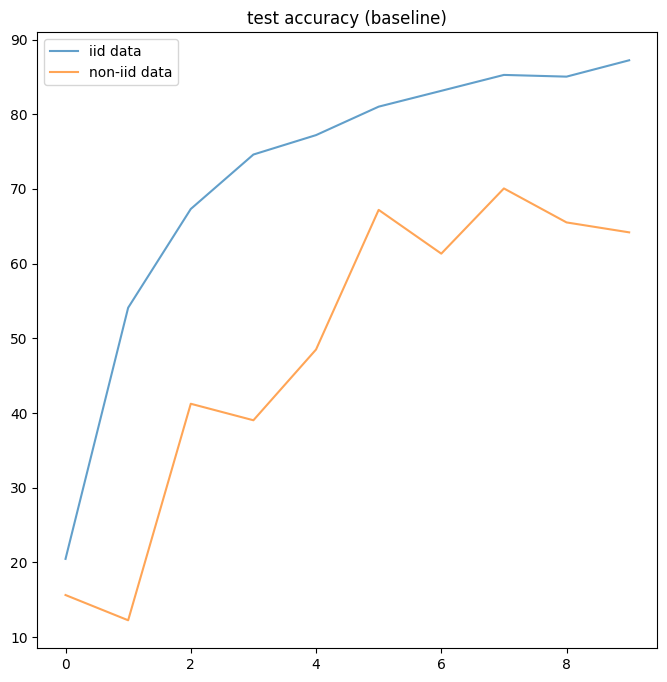

In [19]:
plt.figure(figsize=(8, 8))
plt.title("test accuracy (baseline)")
plt.plot(result_baseline_iid.test_accuracy, label="iid data", alpha=0.7)
plt.plot(result_baseline_non_iid.test_accuracy, label="non-iid data", alpha=0.7)
plt.legend()
# plt.ylim(None, .3)

### benchmarks

In [20]:
type _ClientFactory = typing.Callable[
    [torch.utils.data.Dataset[typing.Any], float, int, int], Client
]


def inject_malicious_clients(
    server: Server,
    malicious_client_factory: _ClientFactory,
):
    clients = server.clients

    # Number of clients to be made malicious with gradient reversion
    num_malicious = int(0.20 * len(clients))  # For example, 20%

    # Randomly select indices for the clients to undergo gradient inversion attack
    generator = np.random.default_rng(43)
    malicious_indices = generator.choice(len(clients), num_malicious, replace=False)

    # Replace the selected clients with instances of AttackerGradientInversion
    print(f"injected malicious clients at indices: {np.sort(malicious_indices)}")

    for idx in malicious_indices:
        client_data = clients[idx].loader_train.dataset
        lr = clients[idx].optimizer.param_groups[0]["lr"]
        batch_size = clients[idx].loader_train.batch_size
        nr_epochs = clients[idx].nr_epochs

        clients[idx] = malicious_client_factory(client_data, lr, batch_size, nr_epochs)


def configure_server_index(dataset: SplitDataset, defense: typing.Any) -> Server:
    server = FedAvgServerDefense(
        lr=0.02,
        batch_size=200,
        client_subsets=dataset,
        client_fraction=0.2,
        nr_local_epochs=2,
        seed=42,
        defense=defense,
    )

    inject_malicious_clients(
        server, malicious_client_factory=build_gradient_reversion_client
    )
    return server


def configure_server_parameter(dataset: SplitDataset, defense: typing.Any) -> Server:
    server = FedAvgServerDefenseCoordinate(
        lr=0.02,
        batch_size=200,
        client_subsets=dataset,
        client_fraction=0.2,
        nr_local_epochs=2,
        seed=42,
        defense=defense,
    )

    inject_malicious_clients(
        server, malicious_client_factory=build_gradient_reversion_client
    )
    return server


def run_training(
    iid: bool, method: typing.Literal["krum", "multi-krum", "majority-sign"] | None
) -> RunResult:
    dataset = split(nr_clients=100, iid=iid, seed=42)

    match method:
        case "krum":
            return configure_server_index(dataset=dataset, defense=krum).run(10)
        case "multi-krum":
            return configure_server_index(dataset=dataset, defense=multi_krum).run(10)
        case "majority-sign":
            return configure_server_parameter(dataset=dataset, defense=majority_sign_filter).run(10)
        case None:
            return configure_server_index(dataset=dataset, defense=None).run(10)
            # 77.2, 81.01, 83.13, 85.26, 85.03, 87.22])
            #return FedAvgGradServer(0.02, 200, sample_split, 0.2, 2, 42).run(10)

In [21]:
defense_mechanism_variants = ["krum", "multi-krum", "majority-sign", None]

In [22]:
results_defense_mechanism_iid = [
    run_training(iid=True, method=method)
    for method in tqdm(defense_mechanism_variants, "defense mechanism", leave=False)
]

defense mechanism:   0%|          | 0/4 [00:00<?, ?it/s]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [71] (whereof 0 are malicious)


selected clients: [84] (whereof 0 are malicious)


selected clients: [28] (whereof 0 are malicious)


selected clients: [11] (whereof 0 are malicious)


selected clients: [15] (whereof 0 are malicious)


selected clients: [9] (whereof 0 are malicious)


selected clients: [32] (whereof 0 are malicious)


selected clients: [95] (whereof 0 are malicious)


selected clients: [81] (whereof 0 are malicious)


selected clients: [81] (whereof 0 are malicious)


defense mechanism:  25%|██▌       | 1/4 [00:55<02:46, 55.57s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [7, 12, 17, 54, 61, 63, 68, 71, 75, 83, 84, 86, 89, 94] (whereof 1 are malicious)


selected clients: [4, 5, 15, 18, 30, 39, 44, 58, 61, 62, 69, 70, 79, 84] (whereof 1 are malicious)


selected clients: [8, 13, 23, 28, 37, 54, 61, 68, 69, 71, 75, 79, 86, 97] (whereof 1 are malicious)


selected clients: [7, 8, 9, 11, 30, 50, 54, 56, 59, 69, 75, 77, 85, 94] (whereof 0 are malicious)


selected clients: [2, 8, 10, 15, 29, 31, 37, 57, 65, 68, 74, 84, 87, 94] (whereof 1 are malicious)


selected clients: [7, 9, 28, 43, 44, 62, 69, 70, 77, 79, 81, 90, 93, 99] (whereof 1 are malicious)


selected clients: [7, 8, 12, 17, 18, 26, 32, 39, 48, 51, 57, 58, 74, 89] (whereof 1 are malicious)


selected clients: [5, 15, 26, 34, 39, 43, 44, 54, 60, 66, 77, 79, 91, 95] (whereof 1 are malicious)


selected clients: [9, 13, 22, 23, 28, 37, 54, 62, 81, 84, 85, 89, 90, 92] (whereof 0 are malicious)


selected clients: [2, 8, 10, 13, 30, 36, 66, 76, 77, 81, 83, 84, 90, 98] (whereof 1 are malicious)


defense mechanism:  50%|█████     | 2/4 [02:13<02:17, 68.69s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


defense mechanism:  75%|███████▌  | 3/4 [03:06<01:01, 61.39s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [7, 8, 12, 17, 36, 45, 47, 49, 54, 61, 63, 68, 71, 73, 75, 83, 84, 86, 89, 94] (whereof 5 are malicious)


selected clients: [4, 5, 13, 15, 18, 30, 34, 39, 44, 47, 51, 53, 58, 61, 62, 69, 70, 74, 79, 84] (whereof 2 are malicious)


selected clients: [8, 13, 23, 28, 36, 37, 40, 45, 54, 61, 68, 69, 71, 75, 76, 78, 79, 86, 87, 97] (whereof 6 are malicious)


selected clients: [7, 8, 9, 11, 20, 30, 36, 40, 50, 52, 53, 54, 56, 59, 60, 69, 75, 77, 85, 94] (whereof 5 are malicious)


selected clients: [2, 8, 10, 15, 29, 31, 35, 37, 41, 45, 46, 57, 65, 68, 70, 73, 74, 84, 87, 94] (whereof 5 are malicious)


selected clients: [7, 9, 24, 25, 28, 31, 41, 43, 44, 62, 69, 70, 73, 77, 79, 81, 83, 90, 93, 99] (whereof 5 are malicious)


selected clients: [3, 7, 8, 12, 17, 18, 26, 32, 36, 39, 48, 51, 53, 55, 57, 58, 70, 74, 89, 93] (whereof 5 are malicious)


selected clients: [5, 7, 15, 24, 26, 34, 39, 40, 43, 44, 45, 52, 54, 60, 66, 77, 79, 87, 91, 95] (whereof 6 are malicious)


selected clients: [3, 9, 13, 20, 21, 22, 23, 28, 37, 54, 55, 62, 67, 81, 84, 85, 89, 90, 92, 98] (whereof 2 are malicious)


selected clients: [2, 3, 8, 10, 13, 20, 24, 30, 33, 36, 45, 49, 66, 76, 77, 81, 83, 84, 90, 98] (whereof 7 are malicious)


In [23]:
results_defense_mechanism_non_iid = [
    run_training(iid=False, method=method)
    for method in tqdm(defense_mechanism_variants, "defense mechanism", leave=False)
]

defense mechanism:   0%|          | 0/4 [00:00<?, ?it/s]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [71] (whereof 0 are malicious)


selected clients: [62] (whereof 0 are malicious)


selected clients: [28] (whereof 0 are malicious)


selected clients: [54] (whereof 0 are malicious)


selected clients: [74] (whereof 0 are malicious)


selected clients: [90] (whereof 0 are malicious)


selected clients: [39] (whereof 0 are malicious)


selected clients: [39] (whereof 0 are malicious)


selected clients: [84] (whereof 0 are malicious)


selected clients: [2] (whereof 0 are malicious)


defense mechanism:  25%|██▌       | 1/4 [01:01<03:05, 61.89s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [7, 8, 12, 17, 47, 54, 61, 63, 68, 71, 83, 84, 89, 94] (whereof 1 are malicious)


selected clients: [4, 5, 13, 15, 18, 34, 44, 58, 61, 62, 69, 74, 79, 84] (whereof 0 are malicious)


selected clients: [8, 13, 23, 28, 37, 54, 68, 69, 71, 75, 76, 79, 86, 97] (whereof 1 are malicious)


selected clients: [7, 8, 9, 11, 20, 30, 50, 54, 60, 69, 75, 77, 85, 94] (whereof 1 are malicious)


selected clients: [2, 8, 10, 15, 29, 31, 35, 37, 46, 57, 65, 84, 87, 94] (whereof 1 are malicious)


selected clients: [7, 9, 28, 31, 43, 44, 62, 69, 70, 77, 79, 90, 93, 99] (whereof 1 are malicious)


selected clients: [7, 12, 17, 18, 26, 32, 39, 48, 55, 57, 58, 74, 89, 93] (whereof 1 are malicious)


selected clients: [5, 7, 15, 26, 34, 39, 43, 44, 54, 66, 77, 79, 91, 95] (whereof 1 are malicious)


selected clients: [9, 13, 22, 28, 37, 54, 62, 67, 81, 84, 89, 90, 92, 98] (whereof 0 are malicious)


selected clients: [2, 3, 8, 10, 13, 30, 36, 66, 76, 77, 83, 84, 90, 98] (whereof 2 are malicious)


defense mechanism:  50%|█████     | 2/4 [02:28<02:32, 76.17s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


defense mechanism:  75%|███████▌  | 3/4 [03:25<01:07, 67.60s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [7, 8, 12, 17, 36, 45, 47, 49, 54, 61, 63, 68, 71, 73, 75, 83, 84, 86, 89, 94] (whereof 5 are malicious)


selected clients: [4, 5, 13, 15, 18, 30, 34, 39, 44, 47, 51, 53, 58, 61, 62, 69, 70, 74, 79, 84] (whereof 2 are malicious)


selected clients: [8, 13, 23, 28, 36, 37, 40, 45, 54, 61, 68, 69, 71, 75, 76, 78, 79, 86, 87, 97] (whereof 6 are malicious)


selected clients: [7, 8, 9, 11, 20, 30, 36, 40, 50, 52, 53, 54, 56, 59, 60, 69, 75, 77, 85, 94] (whereof 5 are malicious)


selected clients: [2, 8, 10, 15, 29, 31, 35, 37, 41, 45, 46, 57, 65, 68, 70, 73, 74, 84, 87, 94] (whereof 5 are malicious)


selected clients: [7, 9, 24, 25, 28, 31, 41, 43, 44, 62, 69, 70, 73, 77, 79, 81, 83, 90, 93, 99] (whereof 5 are malicious)


selected clients: [3, 7, 8, 12, 17, 18, 26, 32, 36, 39, 48, 51, 53, 55, 57, 58, 70, 74, 89, 93] (whereof 5 are malicious)


selected clients: [5, 7, 15, 24, 26, 34, 39, 40, 43, 44, 45, 52, 54, 60, 66, 77, 79, 87, 91, 95] (whereof 6 are malicious)


selected clients: [3, 9, 13, 20, 21, 22, 23, 28, 37, 54, 55, 62, 67, 81, 84, 85, 89, 90, 92, 98] (whereof 2 are malicious)


selected clients: [2, 3, 8, 10, 13, 20, 24, 30, 33, 36, 45, 49, 66, 76, 77, 81, 83, 84, 90, 98] (whereof 7 are malicious)


In [24]:
results_defense_mechanism_iid[2].as_df()

,Round,Algorithm,N,C,B,E,η,Seed,Message count,Test accuracy
0,1,FedAvg,100,0.2,200,2,0.02,42,40,10.02
1,2,FedAvg,100,0.2,200,2,0.02,42,80,46.92
2,3,FedAvg,100,0.2,200,2,0.02,42,120,58.83
3,4,FedAvg,100,0.2,200,2,0.02,42,160,72.07
4,5,FedAvg,100,0.2,200,2,0.02,42,200,75.85
5,6,FedAvg,100,0.2,200,2,0.02,42,240,76.84
6,7,FedAvg,100,0.2,200,2,0.02,42,280,79.14
7,8,FedAvg,100,0.2,200,2,0.02,42,320,79.42
8,9,FedAvg,100,0.2,200,2,0.02,42,360,81.99
9,10,FedAvg,100,0.2,200,2,0.02,42,400,83.96


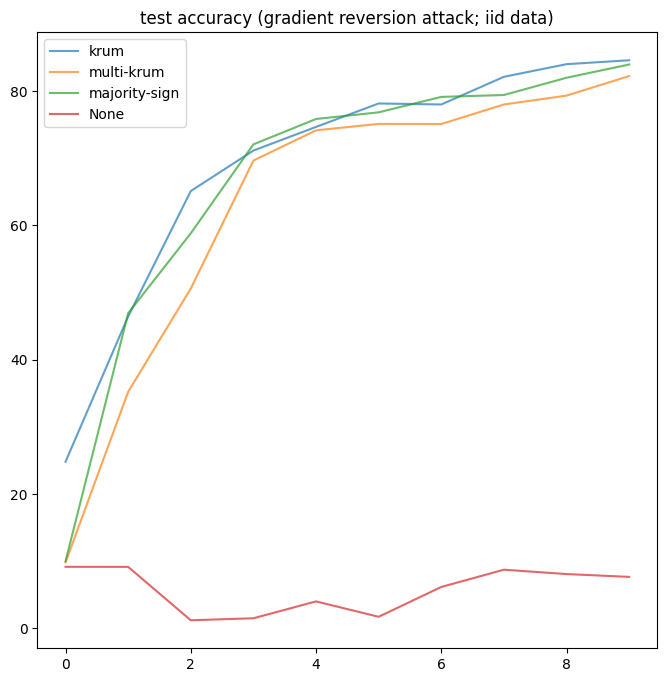

In [25]:
plt.figure(figsize=(8, 8))
plt.title("test accuracy (gradient reversion attack; iid data)")
for statistics, variant_parameters in zip(results_defense_mechanism_iid, defense_mechanism_variants):
    plt.plot(statistics.test_accuracy, label=f"{variant_parameters}", alpha=0.7)
plt.legend()

Performing training in presence of malicious clients (here: 20% of all clients; gradient reversion attack) without any defense mechanism in place causes the test accuracy to fluctuate around 10 percentage points.
All three considered defense mechanisms (krum, multi-krum and majority sign) are able to mitigate the attack to a large extent, yielding test accuracies in the range of 82 to 84 percentage points.
This is only slightly less than what we observed in our baseline training, wherein the final model scored a test accuracy of 87.22 percentage points.

We observe that all three defense mechanisms are almost equally effective.
Multi-krum performs slightly worse (approx. 2 percentage points) than the other defensive mechanisms.
Since we perform only a single training run per defense mechanism and only test for one hyperparameter configuration, this is not indicative of a general inferiority.

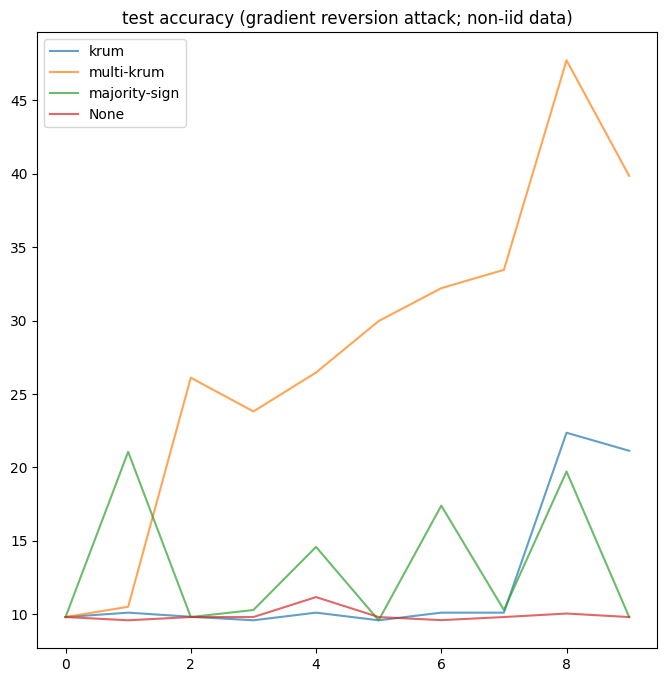

In [26]:
plt.figure(figsize=(8, 8))
plt.title("test accuracy (gradient reversion attack; non-iid data)")
for statistics, variant_parameters in zip(results_defense_mechanism_non_iid, defense_mechanism_variants):
    plt.plot(statistics.test_accuracy, label=f"{variant_parameters}", alpha=0.7)
plt.legend()

If we repeat the experiment with the same setup but assume clients to have heterogeneous datasets, we obtain very different results.

- no defense mechanism: As before, not applying any defense mechanism at all causes the test accuracy to fluctuate around 10 percentage points.
  The corresponding plot is much smoother than it was in the iid setting.

- multi-krum: Unlike before, multi-krum now clearly outperforms all other defense mechanisms that we have considered. 
  Test accuracy peaks with almost 48 percentage points in the penultimate iteration before it goes down to 40 percentage points in the last iteration.

  While multi-krum performs best among all defense mechanisms we have considered, it performs still considerably worse than our baseline in the non-iid setting.
  The baseline training run peaks at a test accuracy of around 70 percentage in the third last iteration and finishes training with a test accuracy of 64 percentage points.
  This drop in test accuracy is unique to the non-iid setting.
  In the iid setting, test accuracy increased (almost) monotonically.

  The drop in the last iteration is most likely not due to overfitting.
  We observe that out of the 14 clients that multi-krum selects in its default hyperparameter setting, only 0 to 1 clients are malicious.
  This is except for the last iteration, in which multi-krum selects two malicious clients.
  This may have jeopardized the last training iteration.

- krum: Just as the training run without any defense mechanisms in place, the first 8 training iterations with krum fluctuate at around 10 percentage points.
  In the penultimate iteration, the test accuracy jumps to 22 percentage points which is the highest test accuracy that we observe for this mechanism.
  
  Interestingly, the poor performance is apparently not caused by the attempted attack.
  Krum does not select a malicious client in any of the iterations, which conversely implies that all considered updates are benign.
  Therefore, we can follow that poor performance is caused by the heterogeneous data distribution and the fact that we only consider a single update per iteration alone.
  In other words, the local update determined by a single client simply is not good enough of an approximation of the theoretical global update.
  
- majority-sign: For this defense mechanism, the peak in test accuracy of 21 percentage points is already reached in the second iteration.
  This increase from the first to the second iteration is unmatched by any other defense mechanism.
  Throughout training, we observe many of such increases of more than 5 percent.
  After every such peak, however, test accuracy falls to 10 percentage points again.

  As it is a coordinate-wise defense mechanism, the results produced by majority sign are comparatively hard to interpret.
  One attempt would be the following: For every component in an update, majority sign determines the sign that is most prevalent among all updates and filters out all update components that are of opposed sign.
  Generally, we can assume this technique to be effective against gradient reversion techniques as gradient reversion simply flips and amplifies the update vector.
  This works well as long as individual updates are relatively similar to the aggregated update.
  We can expect this to be the case in an iid data setting, which explains why we observed good performance for majority-sign in the previous experiment.
  
  In our experiment in the non-iid setting, however, we re-establish iid-ness at the client level by distributing the data set in a way such that every client has approximately two classes assigned to it.
  Depending on which clients are selected in a given training iteration, this may cause client updates to be very dissimilar.
  Suppose that one client is assigned labels 8 and 9 (recall that training is performed on the MNIST dataset) and another client is assigned labels 1 and 4.
  While the labels and therefore the updates within some client are similar, they clearly are not across clients.
  This breaks the assumption that individual updates are similar to the aggregated update which is inherent to majority sign.
 
  We suppose that the iterations in which test accuracy spiked are iterations with a favorable selection of clients.

## Question 2: Implementing Bulyan Defense (5 points)

[Bulyan defense](https://arxiv.org/abs/1802.07927) combines aspects of `multi-krum` and `trimmed-mean` to protect against sophisticated attacks in federated environments. In this question, you will implement Bulyan by modifying and combining the existing code in the [attacks_and_defenses.ipynb](https://github.com/lydiaYchen/DDL25Spring/blob/main/lab/tutorial_3/attacks_and_defenses.ipynb).

### Scoring:
- _(1 point)_ Modify the server-side code to integrate a two-step defense process where:
  1. A client-wise defense like `multi-krum` filters out suspicious gradients based on their distance metrics.
  2. A coordinate-wise defense like `trimmed-mean` calculates the mean across the remaining gradients after trimming the extremes.
  
- _(1 point)_ Successfully integrate these two defense mechanisms [`multi-krum`, `trimmed-mean`] to implement the Bulyan.
- _(3 points)_ Evaluate the performance of your implemented Bulyan defense against three types of attacks: `AttackerGradientReversion`, `AttackerPartGradientReversion`, and `AttackerBackdoor`. Vary the defense hyperparameters to make your defense defend against these attacks while keeping the data distribution i.i.d. and the attacker's hyperparameters constant as per the template. Document the performance of your defense strategy against these attacks in your notebook.

In [27]:
class CombinedServerDefense(FedAvgGradServer):
    def __init__(
        self,
        lr: float,
        batch_size: int,
        client_subsets: list,
        client_fraction: float,
        nr_local_epochs: int,
        seed: int,
        defense_client_wise=None,
        defense_coordinate_wise=None,
    ):
        super().__init__(
            lr, batch_size, client_subsets, client_fraction, nr_local_epochs, seed
        )
        self._defense_client_wise = defense_client_wise
        self._defense_coordinate_wise = defense_coordinate_wise

    def _sample_clients(self):
        return self.rng.choice(
            self.nr_clients, self.nr_clients_per_round, replace=False
        )

    def _print_selected_clients(self, client_indices: typing.Iterable[int]) -> None:
        ordered_indices = list(sorted(client_indices))
        malicious_indices = list(
            filter(lambda idx: not is_client_benign(self.clients[idx]), ordered_indices)
        )

        print(
            f"selected clients: {ordered_indices} (whereof {len(malicious_indices) } are malicious)"
        )

    def run(self, nr_rounds: int) -> RunResult:
        # The beginning of the method remains unchanged
        elapsed_time = 0.0
        run_result = RunResult(
            self.name,
            self.nr_clients,
            self.client_fraction,
            self.batch_size,
            self.nr_local_epochs,
            self.lr,
            self.seed,
        )

        # Initial server weights
        server_weights = [param.data.clone() for param in self.model.parameters()]
        for nr_round in tqdm(range(nr_rounds), desc="Rounds", leave=False):
            setup_start_time = perf_counter()
            self.model.train()
            weights = [x.detach().cpu().clone() for x in self.model.parameters()]
            indices_chosen_clients = self._sample_clients()
            elapsed_time += perf_counter() - setup_start_time

            update_time = 0.0
            client_updates: list[tuple[int, ClientUpdate]] = []
            for client_idx in indices_chosen_clients.tolist():
                update_start_time = perf_counter()

                client_round_seed = (
                    self.seed + client_idx + 1 + nr_round * self.nr_clients_per_round
                )
                client_weights = self.clients[client_idx].update(
                    weights, client_round_seed
                )
                client_updates.append((client_idx, client_weights))

                update_time = max(update_time, perf_counter() - update_start_time)

            if self._defense_client_wise is not None:
                selected_indices = self._defense_client_wise(client_updates)
            else:
                # Use all updates if no defense is specified
                selected_indices = range(len(client_updates))

            self._print_selected_clients(indices_chosen_clients[selected_indices].tolist())

            chosen_sum_nr_samples = sum(
                self.client_sample_counts[i]
                for i in indices_chosen_clients[selected_indices]
            )
            chosen_adjusted_weights: list[list[torch.Tensor]] = [
                [
                    self.client_sample_counts[indices_chosen_clients[ind]]
                    / chosen_sum_nr_samples
                    * tens
                    for tens in client_updates[ind][1]
                ]
                for ind in selected_indices
            ]

            averaged_gradients: list[torch.Tensor]
            if self._defense_coordinate_wise is not None:
                averaged_gradients = self._defense_coordinate_wise(chosen_adjusted_weights)
            else:
                # Use torch function for summing up
                averaged_gradients = [sum(x) for x in zip(*chosen_adjusted_weights)]

            # Aggregation logic remains the same from this point onwards
            # Note that chosen_adjusted_weights now only contains updates from clients selected by multi_krum
            elapsed_time += update_time
            aggregate_start_time = perf_counter()

            # Update server model with averaged gradients
            with torch.no_grad():
                for server_weight, gradient in zip(server_weights, averaged_gradients):
                    server_weight -= gradient.to(
                        device=device
                    )  # Assume learning rate is absorbed in gradient

            # Distribute updated weights to clients
            with torch.no_grad():
                for param, server_weight in zip(
                    self.model.parameters(), server_weights
                ):
                    param.data[:] = server_weight.data

            elapsed_time += perf_counter() - aggregate_start_time
            run_result.wall_time.append(round(elapsed_time, 1))
            run_result.message_count.append(
                2 * (nr_round + 1) * self.nr_clients_per_round
            )
            run_result.test_accuracy.append(self.test())

        return run_result

In [28]:
def configure_server(
    dataset: SplitDataset,
    defense_client_wise: typing.Any,
    defense_coordinate_wise: typing.Any,
) -> Server:
    server = CombinedServerDefense(
        lr=0.02,
        batch_size=200,
        client_subsets=dataset,
        client_fraction=0.2,
        nr_local_epochs=2,
        seed=42,
        defense_client_wise=defense_client_wise,
        defense_coordinate_wise=defense_coordinate_wise,
    )

    return server

In [29]:
@dataclass
class BulyanParameters:
    krum_considered_update_count: int
    krum_max_malicious_update_count: int
    mean_beta: float


def run_training_bulyan(
    attack_type: typing.Literal[
        "gradient-reversion", "partial-gradient-reversion", "backdoor"
    ],
    parameters: BulyanParameters,
) -> tuple[RunResult, BackdoorEvaluationResult]:
    dataset = split(nr_clients=100, iid=True, seed=42)

    server = configure_server(
        dataset,
        lambda client_updates: multi_krum(
            client_updates,
            considered_update_count=parameters.krum_considered_update_count,
            total_update_count=20,
            max_malicious_update_count=parameters.krum_max_malicious_update_count,
        ),
        lambda all_updates: trimmed_mean(all_updates, beta=parameters.mean_beta),
    )

    match attack_type:
        case "gradient-reversion":
            inject_malicious_clients(
                server, malicious_client_factory=build_gradient_reversion_client
            )
        case "partial-gradient-reversion":
            inject_malicious_clients(
                server, malicious_client_factory=build_partial_gradient_reversion_client
            )
        case 'backdoor':
            inject_malicious_clients(server, malicious_client_factory=build_backdoor_client)

    return server.run(10), evaluate_backdoor(server.model, test_loader, 10)

In [30]:
variants_bulyan = [
    BulyanParameters(14, 1, 0.05),
    BulyanParameters(14, 1, 0.1),
    BulyanParameters(14, 1, 0.2),
    BulyanParameters(14, 1, 0.3),
    BulyanParameters(14, 5, 0.05),
    BulyanParameters(14, 5, 0.1),
    BulyanParameters(14, 5, 0.2),
    BulyanParameters(14, 5, 0.3),
    BulyanParameters(7, 5, 0.05),
    BulyanParameters(7, 5, 0.1),
    BulyanParameters(7, 10, 0.05),
    BulyanParameters(7, 10, 0.1),
]

In [31]:
results_bulyan: list[RunResult] = []
results_backdoor_bulyan: list[BackdoorEvaluationResult] = []

for variant in tqdm(variants_bulyan, "variant", leave=False):
    result, backdoor_result = run_training_bulyan('backdoor', variant)

    results_bulyan.append(result)
    results_backdoor_bulyan.append(backdoor_result)

variant:   0%|          | 0/12 [00:00<?, ?it/s]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [8, 12, 17, 45, 47, 54, 61, 63, 68, 75, 84, 86, 89, 94] (whereof 2 are malicious)


selected clients: [4, 13, 15, 18, 30, 34, 39, 44, 47, 62, 69, 74, 79, 84] (whereof 0 are malicious)


selected clients: [8, 13, 23, 28, 40, 54, 61, 68, 69, 75, 79, 86, 87, 97] (whereof 3 are malicious)


selected clients: [7, 8, 9, 11, 30, 40, 50, 54, 56, 59, 60, 69, 75, 85] (whereof 1 are malicious)


selected clients: [2, 8, 15, 29, 31, 35, 37, 57, 68, 73, 74, 84, 87, 94] (whereof 2 are malicious)


selected clients: [7, 9, 28, 43, 44, 62, 69, 73, 77, 79, 81, 83, 93, 99] (whereof 1 are malicious)


selected clients: [7, 8, 12, 17, 32, 39, 48, 53, 55, 57, 70, 74, 89, 93] (whereof 2 are malicious)


selected clients: [5, 7, 15, 26, 34, 39, 43, 54, 60, 66, 77, 79, 91, 95] (whereof 1 are malicious)


selected clients: [13, 22, 23, 28, 37, 54, 55, 62, 81, 84, 85, 89, 90, 92] (whereof 0 are malicious)


selected clients: [2, 10, 13, 24, 30, 33, 49, 76, 77, 81, 83, 84, 90, 98] (whereof 3 are malicious)


variant:   8%|▊         | 1/12 [01:33<17:09, 93.61s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [8, 12, 17, 45, 47, 54, 61, 63, 68, 75, 84, 86, 89, 94] (whereof 2 are malicious)


selected clients: [4, 15, 18, 30, 34, 39, 44, 47, 58, 62, 69, 74, 79, 84] (whereof 0 are malicious)


selected clients: [8, 13, 23, 40, 54, 61, 68, 69, 71, 75, 79, 86, 87, 97] (whereof 3 are malicious)


selected clients: [7, 8, 9, 11, 40, 50, 54, 56, 59, 60, 69, 77, 85, 94] (whereof 1 are malicious)


selected clients: [2, 8, 15, 29, 35, 37, 46, 57, 68, 73, 74, 84, 87, 94] (whereof 2 are malicious)


selected clients: [7, 9, 28, 43, 44, 69, 70, 77, 79, 81, 83, 90, 93, 99] (whereof 1 are malicious)


selected clients: [7, 8, 17, 18, 32, 39, 48, 55, 57, 58, 70, 74, 89, 93] (whereof 1 are malicious)


selected clients: [5, 7, 34, 40, 43, 44, 54, 60, 66, 77, 79, 87, 91, 95] (whereof 2 are malicious)


selected clients: [9, 13, 21, 22, 28, 37, 54, 55, 62, 81, 84, 89, 90, 92] (whereof 0 are malicious)


selected clients: [2, 3, 10, 13, 24, 30, 49, 76, 77, 81, 83, 84, 90, 98] (whereof 3 are malicious)


variant:  17%|█▋        | 2/12 [03:04<15:20, 92.09s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [8, 12, 17, 45, 47, 54, 61, 63, 68, 75, 84, 86, 89, 94] (whereof 2 are malicious)


selected clients: [4, 15, 18, 30, 34, 39, 44, 47, 58, 62, 69, 74, 79, 84] (whereof 0 are malicious)


selected clients: [8, 13, 23, 28, 40, 54, 61, 68, 71, 75, 79, 86, 87, 97] (whereof 3 are malicious)


selected clients: [8, 9, 11, 20, 30, 40, 50, 54, 60, 69, 75, 77, 85, 94] (whereof 2 are malicious)


selected clients: [2, 8, 15, 29, 31, 35, 37, 46, 57, 68, 74, 84, 87, 94] (whereof 1 are malicious)


selected clients: [7, 9, 28, 31, 43, 44, 69, 70, 77, 81, 83, 90, 93, 99] (whereof 1 are malicious)


selected clients: [7, 8, 12, 17, 18, 39, 48, 55, 57, 58, 70, 74, 89, 93] (whereof 1 are malicious)


selected clients: [5, 7, 24, 34, 40, 43, 44, 54, 60, 66, 77, 79, 87, 91] (whereof 3 are malicious)


selected clients: [13, 21, 22, 23, 28, 37, 54, 55, 62, 81, 84, 85, 89, 92] (whereof 0 are malicious)


selected clients: [2, 3, 10, 13, 24, 30, 49, 76, 77, 81, 83, 84, 90, 98] (whereof 3 are malicious)


variant:  25%|██▌       | 3/12 [04:34<13:40, 91.13s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [8, 12, 17, 45, 47, 54, 61, 63, 68, 75, 84, 86, 89, 94] (whereof 2 are malicious)


selected clients: [4, 13, 15, 18, 30, 34, 39, 47, 58, 62, 69, 74, 79, 84] (whereof 0 are malicious)


selected clients: [8, 13, 23, 40, 54, 61, 68, 69, 71, 75, 79, 86, 87, 97] (whereof 3 are malicious)


selected clients: [8, 9, 11, 20, 30, 40, 50, 54, 60, 69, 75, 77, 85, 94] (whereof 2 are malicious)


selected clients: [2, 8, 15, 29, 31, 35, 37, 46, 57, 68, 74, 84, 87, 94] (whereof 1 are malicious)


selected clients: [7, 9, 28, 31, 43, 44, 69, 70, 77, 81, 83, 90, 93, 99] (whereof 1 are malicious)


selected clients: [7, 8, 12, 17, 18, 39, 48, 55, 57, 58, 70, 74, 89, 93] (whereof 1 are malicious)


selected clients: [5, 7, 24, 34, 40, 43, 44, 54, 60, 66, 77, 79, 87, 91] (whereof 3 are malicious)


selected clients: [9, 13, 21, 22, 28, 37, 54, 55, 62, 81, 84, 89, 90, 92] (whereof 0 are malicious)


selected clients: [2, 3, 10, 13, 24, 30, 49, 76, 77, 81, 83, 84, 90, 98] (whereof 3 are malicious)


variant:  33%|███▎      | 4/12 [06:13<12:32, 94.03s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [7, 12, 17, 54, 61, 63, 68, 71, 75, 83, 84, 86, 89, 94] (whereof 1 are malicious)


selected clients: [4, 15, 18, 30, 34, 39, 44, 47, 58, 61, 62, 69, 79, 84] (whereof 0 are malicious)


selected clients: [8, 13, 23, 28, 37, 54, 61, 68, 69, 71, 75, 76, 86, 97] (whereof 1 are malicious)


selected clients: [7, 8, 9, 11, 20, 30, 50, 54, 56, 60, 69, 75, 85, 94] (whereof 1 are malicious)


selected clients: [2, 8, 10, 15, 31, 35, 37, 46, 65, 68, 74, 84, 87, 94] (whereof 1 are malicious)


selected clients: [7, 9, 28, 31, 44, 62, 69, 70, 77, 79, 81, 90, 93, 99] (whereof 1 are malicious)


selected clients: [7, 8, 12, 18, 26, 32, 39, 48, 51, 55, 58, 74, 89, 93] (whereof 1 are malicious)


selected clients: [5, 7, 15, 26, 34, 39, 43, 44, 54, 60, 66, 77, 91, 95] (whereof 1 are malicious)


selected clients: [13, 22, 23, 28, 37, 54, 55, 62, 81, 84, 85, 89, 90, 92] (whereof 0 are malicious)


selected clients: [2, 10, 13, 20, 30, 36, 66, 76, 77, 81, 83, 84, 90, 98] (whereof 2 are malicious)


variant:  42%|████▏     | 5/12 [07:53<11:13, 96.21s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [7, 12, 17, 54, 61, 63, 68, 71, 75, 83, 84, 86, 89, 94] (whereof 1 are malicious)


selected clients: [4, 15, 18, 30, 34, 39, 44, 47, 58, 61, 62, 69, 79, 84] (whereof 0 are malicious)


selected clients: [8, 13, 23, 28, 37, 54, 61, 68, 69, 71, 75, 76, 86, 97] (whereof 1 are malicious)


selected clients: [7, 8, 9, 11, 20, 30, 50, 54, 56, 60, 69, 75, 85, 94] (whereof 1 are malicious)


selected clients: [2, 8, 10, 15, 31, 35, 37, 46, 65, 68, 74, 84, 87, 94] (whereof 1 are malicious)


selected clients: [7, 9, 28, 31, 43, 62, 69, 70, 77, 81, 83, 90, 93, 99] (whereof 1 are malicious)


selected clients: [7, 8, 12, 18, 26, 32, 39, 48, 51, 55, 58, 74, 89, 93] (whereof 1 are malicious)


selected clients: [5, 7, 15, 26, 34, 39, 43, 44, 54, 60, 66, 77, 91, 95] (whereof 1 are malicious)


selected clients: [13, 22, 23, 28, 37, 54, 55, 62, 81, 84, 85, 89, 90, 92] (whereof 0 are malicious)


selected clients: [2, 10, 13, 20, 30, 36, 66, 76, 77, 81, 83, 84, 90, 98] (whereof 2 are malicious)


variant:  50%|█████     | 6/12 [09:41<10:01, 100.24s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [7, 12, 17, 54, 61, 63, 68, 71, 75, 83, 84, 86, 89, 94] (whereof 1 are malicious)


selected clients: [4, 15, 18, 30, 34, 39, 44, 47, 58, 61, 62, 69, 79, 84] (whereof 0 are malicious)


selected clients: [8, 13, 23, 28, 37, 54, 61, 68, 69, 71, 75, 76, 86, 97] (whereof 1 are malicious)


selected clients: [7, 8, 9, 11, 30, 50, 54, 56, 60, 69, 75, 77, 85, 94] (whereof 0 are malicious)


selected clients: [2, 8, 10, 15, 31, 35, 37, 46, 65, 68, 74, 84, 87, 94] (whereof 1 are malicious)


selected clients: [7, 9, 28, 31, 43, 62, 69, 70, 77, 81, 83, 90, 93, 99] (whereof 1 are malicious)


selected clients: [7, 8, 12, 18, 26, 32, 39, 48, 51, 55, 58, 74, 89, 93] (whereof 1 are malicious)


selected clients: [5, 7, 15, 26, 34, 39, 43, 44, 54, 60, 66, 77, 91, 95] (whereof 1 are malicious)


selected clients: [13, 22, 23, 28, 37, 54, 55, 62, 81, 84, 85, 89, 90, 92] (whereof 0 are malicious)


selected clients: [2, 10, 13, 20, 30, 36, 66, 76, 77, 81, 83, 84, 90, 98] (whereof 2 are malicious)


variant:  58%|█████▊    | 7/12 [11:38<08:49, 105.81s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [7, 12, 17, 54, 61, 63, 68, 71, 75, 83, 84, 86, 89, 94] (whereof 1 are malicious)


selected clients: [4, 15, 18, 30, 34, 39, 44, 47, 58, 61, 62, 69, 79, 84] (whereof 0 are malicious)


selected clients: [8, 13, 23, 28, 37, 54, 61, 68, 69, 71, 75, 76, 86, 97] (whereof 1 are malicious)


selected clients: [7, 8, 9, 11, 30, 50, 54, 56, 60, 69, 75, 77, 85, 94] (whereof 0 are malicious)


selected clients: [2, 8, 10, 15, 31, 35, 37, 46, 57, 65, 68, 84, 87, 94] (whereof 1 are malicious)


selected clients: [7, 9, 28, 31, 43, 62, 69, 70, 77, 81, 83, 90, 93, 99] (whereof 1 are malicious)


selected clients: [7, 8, 12, 18, 26, 32, 39, 48, 51, 55, 58, 74, 89, 93] (whereof 1 are malicious)


selected clients: [5, 7, 15, 26, 34, 39, 43, 44, 54, 60, 66, 77, 91, 95] (whereof 1 are malicious)


selected clients: [9, 13, 22, 23, 28, 37, 54, 55, 62, 81, 84, 85, 89, 90] (whereof 0 are malicious)


selected clients: [2, 10, 13, 20, 30, 36, 66, 76, 77, 81, 83, 84, 90, 98] (whereof 2 are malicious)


variant:  67%|██████▋   | 8/12 [13:28<07:08, 107.07s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [54, 61, 71, 75, 83, 84, 89] (whereof 0 are malicious)


selected clients: [4, 18, 30, 39, 69, 79, 84] (whereof 0 are malicious)


selected clients: [13, 28, 37, 68, 69, 75, 76] (whereof 0 are malicious)


selected clients: [9, 30, 54, 59, 69, 75, 94] (whereof 0 are malicious)


selected clients: [2, 8, 31, 35, 65, 74, 94] (whereof 0 are malicious)


selected clients: [9, 28, 44, 69, 77, 90, 93] (whereof 0 are malicious)


selected clients: [7, 8, 12, 17, 48, 55, 74] (whereof 0 are malicious)


selected clients: [7, 34, 54, 66, 77, 91, 95] (whereof 0 are malicious)


selected clients: [13, 22, 54, 84, 89, 92, 98] (whereof 0 are malicious)


selected clients: [2, 8, 10, 76, 77, 83, 90] (whereof 0 are malicious)


variant:  75%|███████▌  | 9/12 [15:16<05:22, 107.55s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [54, 61, 71, 75, 83, 84, 89] (whereof 0 are malicious)


selected clients: [4, 18, 30, 39, 69, 79, 84] (whereof 0 are malicious)


selected clients: [13, 28, 37, 68, 69, 75, 76] (whereof 0 are malicious)


selected clients: [9, 30, 54, 59, 69, 75, 94] (whereof 0 are malicious)


selected clients: [2, 8, 31, 35, 65, 74, 94] (whereof 0 are malicious)


selected clients: [7, 9, 28, 69, 77, 90, 93] (whereof 0 are malicious)


selected clients: [12, 17, 18, 48, 55, 58, 89] (whereof 0 are malicious)


selected clients: [7, 15, 34, 54, 77, 91, 95] (whereof 0 are malicious)


selected clients: [9, 54, 62, 84, 90, 92, 98] (whereof 0 are malicious)


selected clients: [2, 10, 13, 76, 77, 90, 98] (whereof 0 are malicious)


variant:  83%|████████▎ | 10/12 [17:08<03:37, 108.88s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [17, 47, 68, 71, 75, 86, 89] (whereof 0 are malicious)


selected clients: [18, 34, 39, 62, 69, 79, 84] (whereof 0 are malicious)


selected clients: [8, 13, 28, 37, 68, 69, 76] (whereof 0 are malicious)


selected clients: [9, 30, 50, 54, 69, 77, 94] (whereof 0 are malicious)


selected clients: [2, 8, 15, 31, 35, 65, 94] (whereof 0 are malicious)


selected clients: [9, 28, 44, 69, 77, 81, 93] (whereof 0 are malicious)


selected clients: [7, 8, 17, 18, 39, 55, 74] (whereof 0 are malicious)


selected clients: [7, 34, 54, 66, 77, 91, 95] (whereof 0 are malicious)


selected clients: [13, 22, 28, 37, 54, 90, 92] (whereof 0 are malicious)


selected clients: [30, 66, 76, 77, 81, 83, 84] (whereof 0 are malicious)


variant:  92%|█████████▏| 11/12 [19:01<01:50, 110.06s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [17, 47, 68, 71, 75, 86, 89] (whereof 0 are malicious)


selected clients: [4, 18, 30, 39, 69, 79, 84] (whereof 0 are malicious)


selected clients: [8, 13, 28, 37, 68, 69, 76] (whereof 0 are malicious)


selected clients: [9, 30, 59, 69, 75, 77, 94] (whereof 0 are malicious)


selected clients: [2, 8, 31, 35, 65, 84, 94] (whereof 0 are malicious)


selected clients: [9, 28, 31, 77, 81, 93, 99] (whereof 0 are malicious)


selected clients: [12, 17, 39, 48, 55, 57, 74] (whereof 0 are malicious)


selected clients: [5, 15, 39, 54, 66, 91, 95] (whereof 0 are malicious)


selected clients: [13, 22, 28, 37, 54, 55, 92] (whereof 0 are malicious)


selected clients: [8, 13, 76, 77, 81, 83, 90] (whereof 0 are malicious)


In [32]:
results_bulyan_reversion: list[RunResult] = []

for variant in tqdm(variants_bulyan, "variant", leave=False):
    result, _ = run_training_bulyan('gradient-reversion', variant)

    results_bulyan_reversion.append(result)

variant:   0%|          | 0/12 [00:00<?, ?it/s]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [7, 12, 17, 47, 54, 61, 63, 68, 71, 75, 83, 86, 89, 94] (whereof 1 are malicious)


selected clients: [4, 13, 15, 18, 30, 34, 39, 47, 58, 62, 69, 74, 79, 84] (whereof 0 are malicious)


selected clients: [13, 23, 28, 36, 37, 40, 54, 68, 69, 71, 75, 76, 86, 97] (whereof 3 are malicious)


selected clients: [7, 9, 11, 20, 30, 50, 52, 54, 56, 59, 69, 75, 77, 85] (whereof 2 are malicious)


selected clients: [2, 10, 15, 29, 35, 37, 46, 57, 65, 68, 73, 74, 87, 94] (whereof 2 are malicious)


selected clients: [7, 9, 25, 28, 43, 44, 62, 70, 77, 79, 83, 90, 93, 99] (whereof 2 are malicious)


selected clients: [3, 7, 18, 32, 39, 48, 51, 55, 57, 58, 70, 74, 89, 93] (whereof 2 are malicious)


selected clients: [5, 7, 15, 26, 34, 39, 43, 44, 66, 77, 79, 87, 91, 95] (whereof 2 are malicious)


selected clients: [9, 13, 22, 23, 28, 37, 54, 55, 62, 81, 84, 85, 89, 92] (whereof 0 are malicious)


selected clients: [2, 8, 10, 13, 30, 33, 49, 66, 76, 77, 81, 83, 84, 98] (whereof 2 are malicious)


variant:   8%|▊         | 1/12 [02:11<24:02, 131.14s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [7, 12, 17, 47, 54, 61, 63, 68, 71, 75, 83, 86, 89, 94] (whereof 1 are malicious)


selected clients: [4, 13, 15, 18, 30, 34, 39, 47, 58, 62, 69, 74, 79, 84] (whereof 0 are malicious)


selected clients: [13, 23, 28, 37, 40, 54, 68, 69, 71, 75, 76, 86, 87, 97] (whereof 3 are malicious)


selected clients: [7, 9, 11, 20, 30, 50, 53, 54, 56, 59, 69, 75, 77, 85] (whereof 2 are malicious)


selected clients: [2, 8, 10, 15, 29, 31, 37, 46, 57, 65, 68, 73, 74, 87] (whereof 2 are malicious)


selected clients: [9, 28, 31, 43, 62, 69, 70, 77, 79, 81, 83, 90, 93, 99] (whereof 1 are malicious)


selected clients: [7, 8, 12, 17, 18, 32, 39, 48, 55, 57, 58, 74, 89, 93] (whereof 0 are malicious)


selected clients: [5, 7, 15, 34, 39, 43, 44, 54, 60, 66, 77, 79, 91, 95] (whereof 0 are malicious)


selected clients: [9, 13, 22, 23, 28, 37, 54, 55, 62, 81, 84, 89, 92, 98] (whereof 0 are malicious)


selected clients: [2, 8, 10, 13, 30, 33, 66, 76, 77, 81, 83, 84, 90, 98] (whereof 1 are malicious)


variant:  17%|█▋        | 2/12 [04:19<21:37, 129.76s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [7, 12, 17, 47, 54, 61, 63, 68, 71, 75, 83, 86, 89, 94] (whereof 1 are malicious)


selected clients: [4, 13, 15, 18, 30, 34, 39, 47, 58, 62, 69, 74, 79, 84] (whereof 0 are malicious)


selected clients: [13, 23, 28, 36, 37, 40, 54, 68, 69, 71, 75, 76, 86, 97] (whereof 3 are malicious)


selected clients: [7, 9, 11, 20, 30, 50, 53, 54, 56, 59, 69, 75, 77, 85] (whereof 2 are malicious)


selected clients: [2, 10, 15, 29, 31, 37, 46, 57, 65, 68, 70, 74, 84, 87] (whereof 2 are malicious)


selected clients: [9, 28, 31, 43, 62, 69, 70, 77, 79, 81, 83, 90, 93, 99] (whereof 1 are malicious)


selected clients: [7, 8, 12, 17, 18, 32, 39, 48, 55, 57, 58, 74, 89, 93] (whereof 0 are malicious)


selected clients: [5, 7, 15, 34, 39, 43, 44, 54, 60, 66, 77, 79, 91, 95] (whereof 0 are malicious)


selected clients: [9, 13, 22, 28, 37, 54, 55, 62, 81, 84, 89, 90, 92, 98] (whereof 0 are malicious)


selected clients: [2, 8, 10, 13, 30, 33, 66, 76, 77, 81, 83, 84, 90, 98] (whereof 1 are malicious)


variant:  25%|██▌       | 3/12 [06:32<19:39, 131.05s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [7, 12, 17, 47, 54, 61, 63, 68, 71, 75, 83, 86, 89, 94] (whereof 1 are malicious)


selected clients: [4, 15, 18, 30, 34, 39, 44, 47, 58, 62, 69, 74, 79, 84] (whereof 0 are malicious)


selected clients: [13, 23, 28, 36, 37, 40, 54, 68, 69, 71, 75, 76, 86, 97] (whereof 3 are malicious)


selected clients: [7, 9, 11, 20, 30, 50, 53, 54, 56, 59, 69, 75, 77, 85] (whereof 2 are malicious)


selected clients: [2, 10, 15, 29, 31, 37, 46, 57, 65, 68, 70, 74, 84, 87] (whereof 2 are malicious)


selected clients: [7, 9, 28, 31, 43, 69, 70, 77, 79, 81, 83, 90, 93, 99] (whereof 1 are malicious)


selected clients: [7, 8, 12, 17, 18, 32, 39, 48, 55, 57, 58, 74, 89, 93] (whereof 0 are malicious)


selected clients: [5, 7, 15, 34, 39, 43, 44, 54, 60, 66, 77, 79, 91, 95] (whereof 0 are malicious)


selected clients: [9, 13, 22, 23, 28, 37, 54, 55, 62, 81, 84, 89, 92, 98] (whereof 0 are malicious)


selected clients: [2, 8, 10, 13, 30, 33, 66, 76, 77, 81, 83, 84, 90, 98] (whereof 1 are malicious)


variant:  33%|███▎      | 4/12 [08:42<17:24, 130.60s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [7, 12, 17, 54, 61, 63, 68, 71, 75, 83, 84, 86, 89, 94] (whereof 1 are malicious)


selected clients: [4, 15, 18, 30, 34, 39, 44, 47, 58, 61, 62, 69, 79, 84] (whereof 0 are malicious)


selected clients: [8, 13, 23, 28, 37, 54, 61, 68, 69, 71, 75, 76, 86, 97] (whereof 1 are malicious)


selected clients: [7, 8, 9, 11, 30, 50, 54, 56, 60, 69, 75, 77, 85, 94] (whereof 0 are malicious)


selected clients: [2, 8, 10, 15, 31, 35, 37, 46, 65, 68, 74, 84, 87, 94] (whereof 1 are malicious)


selected clients: [7, 9, 28, 31, 43, 62, 69, 77, 79, 81, 83, 90, 93, 99] (whereof 0 are malicious)


selected clients: [8, 12, 17, 18, 26, 32, 39, 48, 51, 55, 58, 74, 89, 93] (whereof 1 are malicious)


selected clients: [5, 15, 26, 34, 39, 43, 44, 54, 60, 66, 77, 79, 91, 95] (whereof 1 are malicious)


selected clients: [13, 22, 23, 28, 37, 54, 55, 62, 81, 84, 85, 89, 90, 92] (whereof 0 are malicious)


selected clients: [2, 8, 10, 13, 30, 36, 66, 76, 77, 81, 83, 84, 90, 98] (whereof 1 are malicious)


variant:  42%|████▏     | 5/12 [10:52<15:12, 130.31s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [7, 12, 17, 54, 61, 63, 68, 71, 75, 83, 84, 86, 89, 94] (whereof 1 are malicious)


selected clients: [4, 15, 18, 30, 34, 39, 47, 51, 58, 61, 62, 69, 79, 84] (whereof 0 are malicious)


selected clients: [8, 13, 23, 28, 37, 54, 61, 68, 69, 75, 76, 79, 86, 97] (whereof 1 are malicious)


selected clients: [7, 8, 9, 11, 30, 50, 54, 56, 60, 69, 75, 77, 85, 94] (whereof 0 are malicious)


selected clients: [2, 8, 10, 15, 31, 35, 37, 46, 65, 68, 74, 84, 87, 94] (whereof 1 are malicious)


selected clients: [7, 9, 28, 31, 43, 62, 69, 77, 79, 81, 83, 90, 93, 99] (whereof 0 are malicious)


selected clients: [7, 8, 12, 18, 26, 32, 39, 48, 51, 55, 58, 74, 89, 93] (whereof 1 are malicious)


selected clients: [5, 15, 26, 34, 39, 43, 44, 54, 60, 66, 77, 79, 91, 95] (whereof 1 are malicious)


selected clients: [13, 22, 23, 28, 37, 54, 55, 62, 81, 84, 85, 89, 90, 92] (whereof 0 are malicious)


selected clients: [2, 8, 10, 13, 30, 33, 36, 66, 76, 77, 81, 83, 84, 98] (whereof 2 are malicious)


variant:  50%|█████     | 6/12 [12:55<12:46, 127.83s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [7, 12, 17, 54, 61, 63, 68, 71, 75, 83, 84, 86, 89, 94] (whereof 1 are malicious)


selected clients: [4, 15, 18, 30, 34, 39, 44, 47, 58, 61, 62, 69, 79, 84] (whereof 0 are malicious)


selected clients: [8, 13, 23, 28, 37, 54, 61, 68, 69, 71, 75, 76, 86, 97] (whereof 1 are malicious)


selected clients: [7, 8, 9, 11, 30, 50, 54, 56, 59, 69, 75, 77, 85, 94] (whereof 0 are malicious)


selected clients: [2, 8, 10, 15, 31, 35, 37, 46, 65, 68, 74, 84, 87, 94] (whereof 1 are malicious)


selected clients: [7, 9, 28, 31, 43, 62, 69, 77, 79, 81, 83, 90, 93, 99] (whereof 0 are malicious)


selected clients: [7, 8, 12, 18, 26, 32, 39, 48, 51, 55, 58, 74, 89, 93] (whereof 1 are malicious)


selected clients: [5, 15, 26, 34, 39, 43, 44, 54, 60, 66, 77, 79, 91, 95] (whereof 1 are malicious)


selected clients: [13, 22, 23, 28, 37, 54, 55, 62, 81, 84, 85, 89, 90, 92] (whereof 0 are malicious)


selected clients: [2, 8, 10, 13, 30, 33, 36, 66, 76, 77, 81, 83, 84, 98] (whereof 2 are malicious)


variant:  58%|█████▊    | 7/12 [15:02<10:37, 127.52s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [7, 12, 17, 54, 61, 63, 68, 71, 75, 83, 84, 86, 89, 94] (whereof 1 are malicious)


selected clients: [4, 15, 18, 30, 34, 39, 44, 47, 58, 61, 62, 69, 79, 84] (whereof 0 are malicious)


selected clients: [8, 13, 23, 28, 37, 54, 61, 68, 69, 71, 75, 76, 86, 97] (whereof 1 are malicious)


selected clients: [7, 8, 9, 11, 30, 50, 54, 56, 60, 69, 75, 77, 85, 94] (whereof 0 are malicious)


selected clients: [2, 8, 10, 15, 31, 35, 37, 46, 65, 68, 74, 84, 87, 94] (whereof 1 are malicious)


selected clients: [7, 9, 28, 31, 43, 62, 69, 77, 79, 81, 83, 90, 93, 99] (whereof 0 are malicious)


selected clients: [8, 12, 17, 18, 26, 32, 39, 48, 51, 55, 58, 74, 89, 93] (whereof 1 are malicious)


selected clients: [5, 15, 26, 34, 39, 43, 44, 54, 60, 66, 77, 79, 91, 95] (whereof 1 are malicious)


selected clients: [9, 13, 22, 28, 37, 54, 55, 62, 81, 84, 89, 90, 92, 98] (whereof 0 are malicious)


selected clients: [2, 8, 10, 13, 30, 33, 36, 66, 76, 77, 81, 83, 84, 98] (whereof 2 are malicious)


variant:  67%|██████▋   | 8/12 [17:06<08:26, 126.53s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [54, 61, 71, 75, 83, 84, 89] (whereof 0 are malicious)


selected clients: [4, 18, 30, 39, 69, 79, 84] (whereof 0 are malicious)


selected clients: [13, 28, 37, 68, 69, 75, 76] (whereof 0 are malicious)


selected clients: [9, 30, 54, 59, 69, 75, 94] (whereof 0 are malicious)


selected clients: [2, 8, 31, 35, 65, 74, 94] (whereof 0 are malicious)


selected clients: [9, 28, 44, 69, 77, 90, 93] (whereof 0 are malicious)


selected clients: [7, 8, 12, 17, 48, 55, 74] (whereof 0 are malicious)


selected clients: [7, 34, 54, 66, 77, 91, 95] (whereof 0 are malicious)


selected clients: [13, 22, 54, 84, 89, 92, 98] (whereof 0 are malicious)


selected clients: [8, 13, 30, 66, 81, 84, 90] (whereof 0 are malicious)


variant:  75%|███████▌  | 9/12 [19:05<06:12, 124.28s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [54, 61, 71, 75, 83, 84, 89] (whereof 0 are malicious)


selected clients: [4, 18, 30, 39, 69, 79, 84] (whereof 0 are malicious)


selected clients: [13, 28, 37, 68, 69, 75, 76] (whereof 0 are malicious)


selected clients: [9, 30, 54, 59, 69, 75, 94] (whereof 0 are malicious)


selected clients: [2, 8, 31, 35, 65, 74, 94] (whereof 0 are malicious)


selected clients: [7, 9, 28, 69, 77, 90, 93] (whereof 0 are malicious)


selected clients: [12, 17, 18, 48, 55, 58, 89] (whereof 0 are malicious)


selected clients: [7, 15, 34, 54, 77, 91, 95] (whereof 0 are malicious)


selected clients: [9, 54, 62, 84, 90, 92, 98] (whereof 0 are malicious)


selected clients: [8, 13, 30, 66, 77, 81, 84] (whereof 0 are malicious)


variant:  83%|████████▎ | 10/12 [21:00<04:02, 121.37s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [17, 47, 68, 71, 75, 86, 89] (whereof 0 are malicious)


selected clients: [18, 34, 39, 62, 69, 79, 84] (whereof 0 are malicious)


selected clients: [8, 13, 28, 37, 68, 69, 76] (whereof 0 are malicious)


selected clients: [9, 30, 50, 54, 69, 77, 94] (whereof 0 are malicious)


selected clients: [2, 8, 15, 31, 35, 65, 94] (whereof 0 are malicious)


selected clients: [9, 28, 44, 69, 77, 81, 93] (whereof 0 are malicious)


selected clients: [7, 8, 17, 18, 39, 55, 74] (whereof 0 are malicious)


selected clients: [7, 34, 54, 66, 77, 91, 95] (whereof 0 are malicious)


selected clients: [13, 22, 28, 37, 54, 90, 92] (whereof 0 are malicious)


selected clients: [30, 66, 76, 77, 81, 83, 84] (whereof 0 are malicious)


variant:  92%|█████████▏| 11/12 [22:54<01:59, 119.16s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [17, 47, 68, 71, 75, 86, 89] (whereof 0 are malicious)


selected clients: [4, 18, 30, 39, 69, 79, 84] (whereof 0 are malicious)


selected clients: [8, 13, 28, 37, 68, 69, 76] (whereof 0 are malicious)


selected clients: [9, 30, 59, 69, 75, 77, 94] (whereof 0 are malicious)


selected clients: [2, 8, 31, 35, 65, 84, 94] (whereof 0 are malicious)


selected clients: [9, 28, 31, 77, 81, 93, 99] (whereof 0 are malicious)


selected clients: [12, 17, 39, 48, 55, 57, 74] (whereof 0 are malicious)


selected clients: [5, 15, 39, 54, 66, 91, 95] (whereof 0 are malicious)


selected clients: [13, 22, 28, 37, 54, 55, 92] (whereof 0 are malicious)


selected clients: [8, 13, 76, 77, 81, 83, 90] (whereof 0 are malicious)


In [33]:
results_bulyan_partial_reversion: list[RunResult] = []

for variant in tqdm(variants_bulyan, "variant", leave=False):
    result, _ = run_training_bulyan('partial-gradient-reversion', variant)

    results_bulyan_partial_reversion.append(result)

variant:   0%|          | 0/12 [00:00<?, ?it/s]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [7, 12, 17, 45, 47, 54, 68, 71, 73, 75, 83, 86, 89, 94] (whereof 2 are malicious)


selected clients: [4, 13, 15, 18, 30, 34, 39, 47, 58, 62, 69, 74, 79, 84] (whereof 0 are malicious)


selected clients: [13, 23, 28, 37, 40, 54, 68, 69, 71, 75, 78, 79, 86, 97] (whereof 3 are malicious)


selected clients: [7, 9, 11, 20, 30, 36, 50, 54, 56, 59, 69, 75, 77, 94] (whereof 2 are malicious)


selected clients: [8, 15, 29, 35, 37, 45, 46, 57, 65, 68, 70, 74, 84, 94] (whereof 2 are malicious)


selected clients: [7, 9, 25, 28, 43, 44, 62, 70, 77, 79, 83, 90, 93, 99] (whereof 2 are malicious)


selected clients: [7, 17, 18, 32, 39, 48, 51, 53, 55, 57, 58, 70, 74, 89] (whereof 2 are malicious)


selected clients: [5, 7, 15, 24, 34, 40, 43, 44, 45, 54, 60, 77, 91, 95] (whereof 3 are malicious)


selected clients: [9, 21, 22, 23, 28, 37, 54, 62, 67, 81, 84, 85, 89, 90] (whereof 0 are malicious)


selected clients: [2, 8, 13, 20, 36, 45, 49, 66, 77, 81, 83, 84, 90, 98] (whereof 4 are malicious)


variant:   8%|▊         | 1/12 [02:05<23:04, 125.90s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [7, 12, 17, 45, 47, 54, 68, 71, 73, 75, 83, 86, 89, 94] (whereof 2 are malicious)


selected clients: [4, 15, 18, 30, 34, 39, 44, 47, 58, 62, 69, 74, 79, 84] (whereof 0 are malicious)


selected clients: [13, 23, 28, 37, 40, 45, 54, 68, 69, 71, 75, 79, 86, 97] (whereof 3 are malicious)


selected clients: [7, 9, 20, 30, 36, 50, 54, 56, 59, 69, 75, 77, 85, 94] (whereof 2 are malicious)


selected clients: [8, 15, 29, 35, 37, 45, 46, 57, 65, 68, 73, 74, 84, 94] (whereof 2 are malicious)


selected clients: [7, 9, 24, 28, 44, 62, 69, 70, 77, 79, 81, 90, 93, 99] (whereof 2 are malicious)


selected clients: [3, 7, 8, 18, 32, 39, 48, 51, 53, 55, 57, 58, 74, 89] (whereof 2 are malicious)


selected clients: [5, 7, 15, 26, 34, 39, 43, 44, 45, 52, 66, 77, 79, 91] (whereof 3 are malicious)


selected clients: [9, 21, 22, 23, 28, 37, 54, 62, 81, 84, 85, 89, 90, 98] (whereof 0 are malicious)


selected clients: [2, 8, 10, 13, 20, 24, 45, 49, 66, 76, 81, 83, 90, 98] (whereof 4 are malicious)


variant:  17%|█▋        | 2/12 [04:07<20:33, 123.32s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [7, 12, 17, 45, 47, 54, 68, 71, 73, 75, 83, 86, 89, 94] (whereof 2 are malicious)


selected clients: [4, 15, 18, 30, 34, 39, 44, 47, 58, 62, 69, 74, 79, 84] (whereof 0 are malicious)


selected clients: [13, 23, 28, 37, 40, 45, 54, 68, 69, 71, 75, 79, 86, 97] (whereof 3 are malicious)


selected clients: [7, 9, 11, 20, 30, 50, 53, 54, 56, 59, 69, 75, 77, 85] (whereof 2 are malicious)


selected clients: [2, 10, 15, 29, 31, 37, 41, 46, 57, 65, 68, 73, 74, 84] (whereof 2 are malicious)


selected clients: [7, 9, 28, 43, 62, 69, 70, 73, 77, 79, 83, 90, 93, 99] (whereof 2 are malicious)


selected clients: [7, 8, 17, 18, 39, 48, 53, 55, 57, 58, 70, 74, 89, 93] (whereof 2 are malicious)


selected clients: [5, 7, 15, 24, 26, 34, 39, 43, 52, 60, 77, 79, 91, 95] (whereof 3 are malicious)


selected clients: [9, 13, 21, 22, 28, 37, 54, 55, 62, 81, 84, 89, 92, 98] (whereof 0 are malicious)


selected clients: [2, 13, 20, 24, 30, 36, 45, 66, 76, 77, 83, 84, 90, 98] (whereof 4 are malicious)


variant:  25%|██▌       | 3/12 [06:07<18:17, 122.00s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [7, 12, 17, 45, 47, 54, 68, 71, 73, 75, 83, 86, 89, 94] (whereof 2 are malicious)


selected clients: [4, 13, 15, 18, 30, 34, 39, 44, 47, 58, 62, 69, 79, 84] (whereof 0 are malicious)


selected clients: [13, 23, 28, 37, 40, 45, 54, 68, 69, 71, 75, 79, 86, 97] (whereof 3 are malicious)


selected clients: [7, 9, 11, 20, 30, 50, 53, 54, 56, 59, 69, 75, 77, 85] (whereof 2 are malicious)


selected clients: [2, 10, 15, 29, 31, 37, 41, 46, 57, 65, 68, 73, 74, 84] (whereof 2 are malicious)


selected clients: [7, 9, 25, 28, 43, 62, 69, 70, 77, 79, 83, 90, 93, 99] (whereof 2 are malicious)


selected clients: [7, 8, 17, 18, 39, 48, 53, 55, 57, 58, 70, 74, 89, 93] (whereof 2 are malicious)


selected clients: [5, 7, 15, 24, 26, 34, 39, 43, 52, 54, 77, 79, 91, 95] (whereof 3 are malicious)


selected clients: [9, 13, 22, 28, 37, 54, 55, 62, 81, 84, 89, 90, 92, 98] (whereof 0 are malicious)


selected clients: [2, 13, 20, 24, 30, 36, 45, 66, 76, 77, 83, 84, 90, 98] (whereof 4 are malicious)


variant:  33%|███▎      | 4/12 [08:14<16:29, 123.68s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [7, 12, 17, 54, 61, 63, 68, 71, 75, 83, 84, 86, 89, 94] (whereof 1 are malicious)


selected clients: [4, 15, 18, 30, 34, 39, 44, 47, 58, 61, 62, 69, 79, 84] (whereof 0 are malicious)


selected clients: [8, 13, 23, 28, 37, 54, 61, 68, 69, 75, 76, 79, 86, 97] (whereof 1 are malicious)


selected clients: [7, 8, 9, 11, 20, 30, 50, 54, 56, 59, 69, 75, 85, 94] (whereof 1 are malicious)


selected clients: [2, 8, 10, 15, 29, 31, 35, 37, 65, 68, 74, 84, 87, 94] (whereof 1 are malicious)


selected clients: [7, 9, 28, 31, 43, 62, 69, 77, 79, 81, 83, 90, 93, 99] (whereof 0 are malicious)


selected clients: [7, 8, 12, 18, 26, 32, 39, 48, 51, 55, 58, 74, 89, 93] (whereof 1 are malicious)


selected clients: [5, 15, 26, 34, 39, 43, 44, 54, 60, 66, 77, 79, 91, 95] (whereof 1 are malicious)


selected clients: [13, 22, 23, 28, 37, 54, 55, 62, 81, 84, 85, 89, 90, 92] (whereof 0 are malicious)


selected clients: [2, 8, 13, 30, 36, 45, 66, 76, 77, 81, 83, 84, 90, 98] (whereof 2 are malicious)


variant:  42%|████▏     | 5/12 [10:27<14:51, 127.29s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [7, 12, 17, 54, 61, 63, 68, 71, 75, 83, 84, 86, 89, 94] (whereof 1 are malicious)


selected clients: [4, 15, 18, 30, 34, 39, 44, 47, 58, 61, 62, 69, 79, 84] (whereof 0 are malicious)


selected clients: [8, 13, 23, 28, 37, 54, 61, 68, 69, 75, 76, 79, 86, 97] (whereof 1 are malicious)


selected clients: [7, 8, 9, 11, 20, 30, 50, 54, 56, 60, 69, 75, 85, 94] (whereof 1 are malicious)


selected clients: [2, 8, 10, 15, 31, 35, 37, 46, 65, 68, 74, 84, 87, 94] (whereof 1 are malicious)


selected clients: [7, 9, 28, 31, 43, 62, 69, 77, 79, 81, 83, 90, 93, 99] (whereof 0 are malicious)


selected clients: [8, 12, 17, 18, 26, 32, 39, 48, 51, 55, 58, 74, 89, 93] (whereof 1 are malicious)


selected clients: [5, 7, 15, 26, 34, 39, 43, 44, 54, 60, 66, 77, 91, 95] (whereof 1 are malicious)


selected clients: [9, 13, 22, 28, 37, 54, 55, 62, 81, 84, 85, 89, 90, 92] (whereof 0 are malicious)


selected clients: [2, 8, 13, 30, 36, 45, 66, 76, 77, 81, 83, 84, 90, 98] (whereof 2 are malicious)


variant:  50%|█████     | 6/12 [12:28<12:29, 124.96s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [7, 12, 17, 54, 61, 63, 68, 71, 75, 83, 84, 86, 89, 94] (whereof 1 are malicious)


selected clients: [4, 15, 18, 30, 34, 39, 47, 51, 58, 61, 62, 69, 79, 84] (whereof 0 are malicious)


selected clients: [8, 13, 23, 28, 37, 54, 61, 68, 69, 71, 75, 76, 86, 97] (whereof 1 are malicious)


selected clients: [7, 8, 9, 11, 20, 30, 50, 54, 56, 60, 69, 75, 85, 94] (whereof 1 are malicious)


selected clients: [2, 8, 10, 15, 31, 35, 37, 46, 65, 68, 74, 84, 87, 94] (whereof 1 are malicious)


selected clients: [7, 9, 28, 31, 43, 62, 69, 70, 77, 81, 83, 90, 93, 99] (whereof 1 are malicious)


selected clients: [8, 12, 17, 18, 26, 32, 39, 48, 51, 55, 58, 74, 89, 93] (whereof 1 are malicious)


selected clients: [5, 15, 26, 34, 39, 43, 44, 54, 60, 66, 77, 79, 91, 95] (whereof 1 are malicious)


selected clients: [13, 22, 23, 28, 37, 54, 55, 62, 81, 84, 85, 89, 90, 92] (whereof 0 are malicious)


selected clients: [2, 8, 13, 30, 36, 45, 66, 76, 77, 81, 83, 84, 90, 98] (whereof 2 are malicious)


variant:  58%|█████▊    | 7/12 [14:29<10:17, 123.60s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [7, 12, 17, 54, 61, 63, 68, 71, 75, 83, 84, 86, 89, 94] (whereof 1 are malicious)


selected clients: [4, 15, 18, 30, 34, 39, 44, 47, 58, 61, 62, 69, 79, 84] (whereof 0 are malicious)


selected clients: [8, 13, 23, 28, 37, 54, 61, 68, 69, 75, 76, 79, 86, 97] (whereof 1 are malicious)


selected clients: [7, 8, 9, 11, 20, 30, 50, 54, 56, 60, 69, 75, 85, 94] (whereof 1 are malicious)


selected clients: [2, 8, 10, 15, 31, 35, 37, 46, 65, 68, 74, 84, 87, 94] (whereof 1 are malicious)


selected clients: [7, 9, 28, 31, 44, 62, 69, 70, 77, 79, 81, 90, 93, 99] (whereof 1 are malicious)


selected clients: [8, 12, 17, 18, 26, 32, 39, 48, 51, 55, 58, 74, 89, 93] (whereof 1 are malicious)


selected clients: [5, 15, 26, 34, 39, 43, 44, 54, 60, 66, 77, 79, 91, 95] (whereof 1 are malicious)


selected clients: [13, 22, 23, 28, 37, 54, 55, 62, 81, 84, 85, 89, 90, 92] (whereof 0 are malicious)


selected clients: [2, 8, 13, 30, 36, 45, 66, 76, 77, 81, 83, 84, 90, 98] (whereof 2 are malicious)


variant:  67%|██████▋   | 8/12 [16:32<08:13, 123.45s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [54, 61, 71, 75, 83, 84, 89] (whereof 0 are malicious)


selected clients: [4, 18, 30, 39, 69, 79, 84] (whereof 0 are malicious)


selected clients: [13, 28, 37, 68, 69, 75, 76] (whereof 0 are malicious)


selected clients: [9, 30, 54, 59, 69, 75, 94] (whereof 0 are malicious)


selected clients: [2, 8, 31, 35, 65, 74, 94] (whereof 0 are malicious)


selected clients: [9, 28, 44, 69, 77, 90, 93] (whereof 0 are malicious)


selected clients: [7, 8, 12, 17, 48, 55, 74] (whereof 0 are malicious)


selected clients: [7, 34, 54, 66, 77, 91, 95] (whereof 0 are malicious)


selected clients: [13, 22, 54, 84, 89, 92, 98] (whereof 0 are malicious)


selected clients: [8, 66, 76, 77, 81, 84, 98] (whereof 0 are malicious)


variant:  75%|███████▌  | 9/12 [18:20<05:56, 118.69s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [54, 61, 71, 75, 83, 84, 89] (whereof 0 are malicious)


selected clients: [4, 18, 30, 39, 69, 79, 84] (whereof 0 are malicious)


selected clients: [13, 28, 37, 68, 69, 75, 76] (whereof 0 are malicious)


selected clients: [9, 30, 54, 59, 69, 75, 94] (whereof 0 are malicious)


selected clients: [2, 8, 31, 35, 65, 74, 94] (whereof 0 are malicious)


selected clients: [7, 9, 28, 69, 77, 90, 93] (whereof 0 are malicious)


selected clients: [12, 17, 18, 48, 55, 58, 89] (whereof 0 are malicious)


selected clients: [7, 15, 34, 54, 77, 91, 95] (whereof 0 are malicious)


selected clients: [9, 54, 62, 84, 90, 92, 98] (whereof 0 are malicious)


selected clients: [8, 13, 66, 76, 81, 83, 84] (whereof 0 are malicious)


variant:  83%|████████▎ | 10/12 [20:09<03:51, 115.76s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [17, 47, 68, 71, 75, 86, 89] (whereof 0 are malicious)


selected clients: [18, 34, 39, 62, 69, 79, 84] (whereof 0 are malicious)


selected clients: [8, 13, 28, 37, 68, 69, 76] (whereof 0 are malicious)


selected clients: [9, 30, 50, 54, 69, 77, 94] (whereof 0 are malicious)


selected clients: [2, 8, 15, 31, 35, 65, 94] (whereof 0 are malicious)


selected clients: [9, 28, 44, 69, 77, 81, 93] (whereof 0 are malicious)


selected clients: [7, 8, 17, 18, 39, 55, 74] (whereof 0 are malicious)


selected clients: [7, 34, 54, 66, 77, 91, 95] (whereof 0 are malicious)


selected clients: [13, 22, 28, 37, 54, 90, 92] (whereof 0 are malicious)


selected clients: [30, 66, 76, 77, 81, 83, 84] (whereof 0 are malicious)


variant:  92%|█████████▏| 11/12 [22:01<01:54, 114.50s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [17, 47, 68, 71, 75, 86, 89] (whereof 0 are malicious)


selected clients: [4, 18, 30, 39, 69, 79, 84] (whereof 0 are malicious)


selected clients: [8, 13, 28, 37, 68, 69, 76] (whereof 0 are malicious)


selected clients: [9, 30, 59, 69, 75, 77, 94] (whereof 0 are malicious)


selected clients: [2, 8, 31, 35, 65, 84, 94] (whereof 0 are malicious)


selected clients: [9, 28, 31, 77, 81, 93, 99] (whereof 0 are malicious)


selected clients: [12, 17, 39, 48, 55, 57, 74] (whereof 0 are malicious)


selected clients: [5, 15, 39, 54, 66, 91, 95] (whereof 0 are malicious)


selected clients: [13, 22, 28, 37, 54, 55, 92] (whereof 0 are malicious)


selected clients: [8, 13, 76, 77, 81, 83, 90] (whereof 0 are malicious)


In [34]:
def _format_bulyan_parameters(parameters: BulyanParameters) -> str:
    return (
        # f"k = {parameters.krum_considered_update_count}, "
        # f"m = {parameters.krum_max_malicious_update_count}, "
        f"beta = {parameters.mean_beta}"
    )


def _plot_bulyan(
    axis,
    title: str,
    results: list[RunResult],
    predicate: typing.Callable[[BulyanParameters], bool],
) -> None:
    axis.title.set_text(title)
    for statistics, variant_parameters in zip(
        results,
        variants_bulyan,
    ):
        if not predicate(variant_parameters):
            continue

        axis.plot(
            statistics.test_accuracy,
            label=_format_bulyan_parameters(variant_parameters),
            alpha=0.7,
        )
    axis.legend()
    axis.set_ylim(20, 90)

In [35]:
def _plot_bulyan_results(results: list[RunResult], attack_name: str):
    fig, axes = plt.subplots(1, 4, figsize=(24, 10))

    fig.suptitle(f"test accuracy ({attack_name} attack, bulyan defense)")
    _plot_bulyan(
        axes.flatten()[0],
        "k = 14, m = 5",
        results,
        lambda it: it.krum_considered_update_count == 14
        and it.krum_max_malicious_update_count == 5,
    )
    _plot_bulyan(
        axes.flatten()[1],
        "k = 14, m = 1",
        results,
        lambda it: it.krum_considered_update_count == 14
        and it.krum_max_malicious_update_count == 1,
    )
    _plot_bulyan(
        axes.flatten()[2],
        "k = 7, m = 5",
        results,
        lambda it: it.krum_considered_update_count == 7
        and it.krum_max_malicious_update_count == 5,
    )
    _plot_bulyan(
        axes.flatten()[3],
        "k = 7, m = 10",
        results,
        lambda it: it.krum_considered_update_count == 7
        and it.krum_max_malicious_update_count == 10,
    )

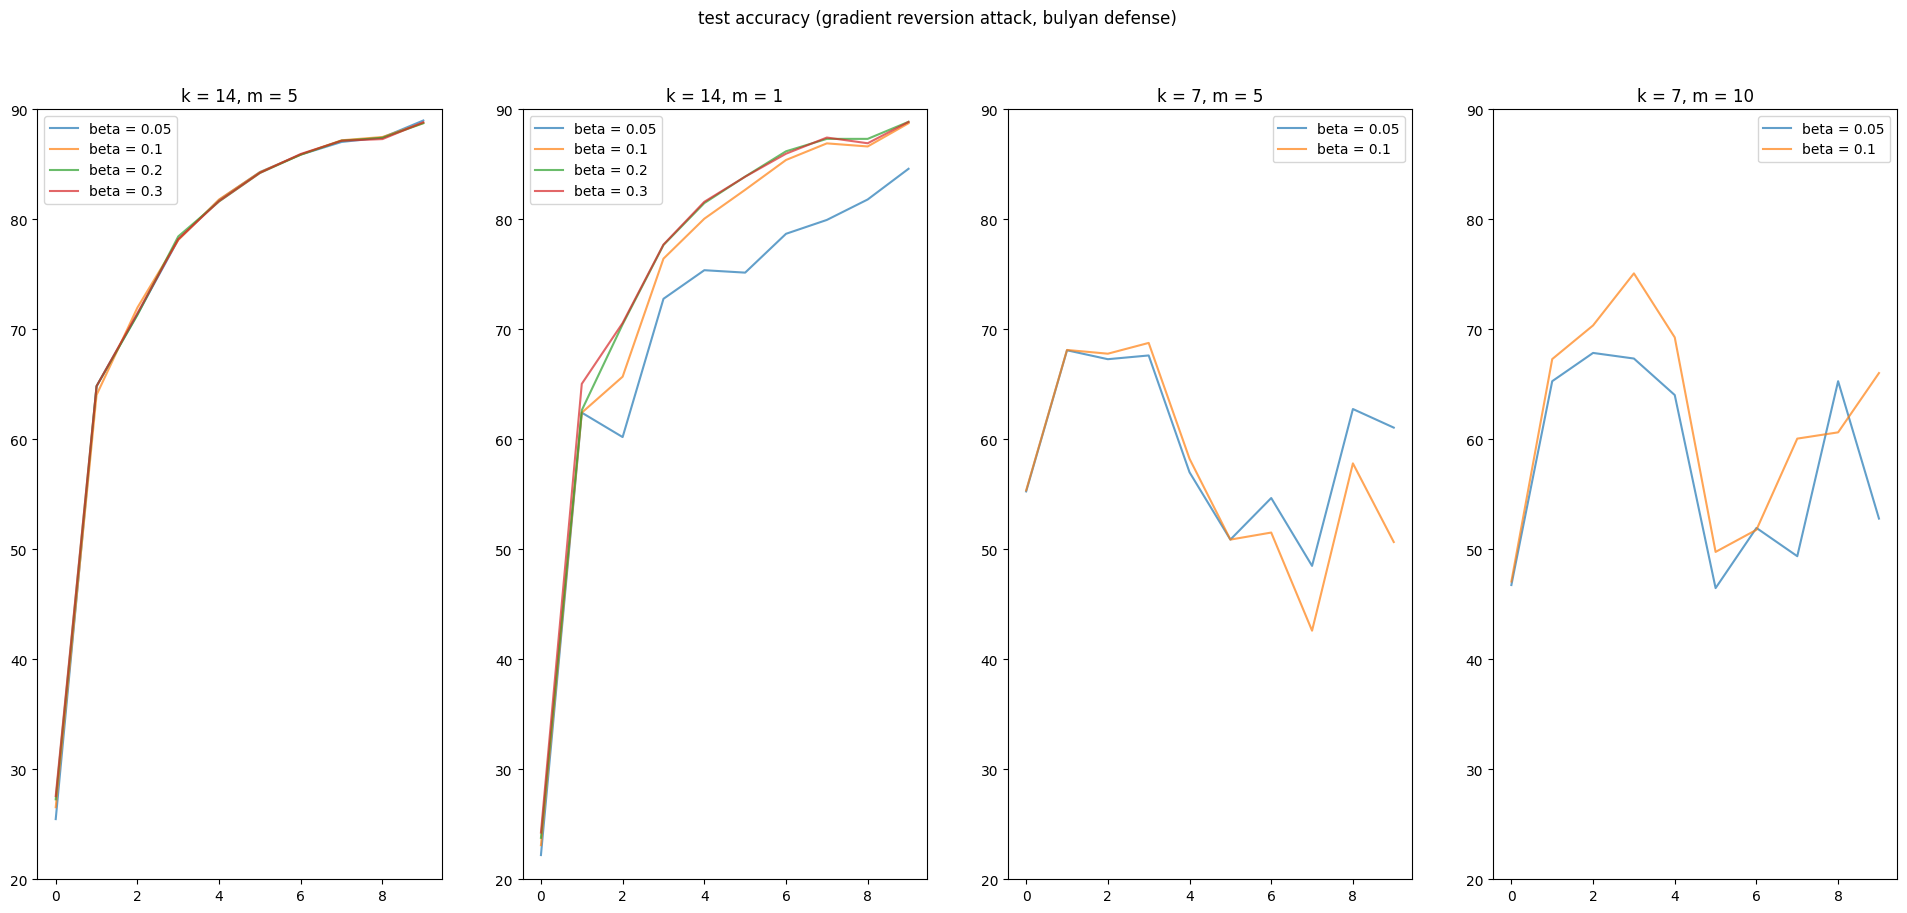

In [36]:
_plot_bulyan_results(results_bulyan_reversion, "gradient reversion")

In gradient reversion attacks, a malicious client simply flips and amplifies the locally determined update vector.

The trimmed mean implementation used by the bulyan defense mechanism assumes a total of 20 malicious clients.
Together with the hyperparameter beta, the number of clients that we assume to be malicious determines how many of the most extreme (smallest and largest) updates we exclude from the aggregated update.
Under our assumption, the following values for beta translate to the following number of excluded updates:

| beta | excluded updates at lower end/upper end (respectively) | excluded updates in total |
| --- | --- | --- |
| 0.05 | 1 | 2 |
| 0.1 | 2 | 4 |
| 0.2 | 4 | 8 |
| 0.3 | 6 | 12 |

We observe that for hyperparameter `k = 14` (i.e., we configure multi-krum to select exactly 14 updates), the bulyan defense mechanism performs generally well.

For `m = 5` specifically, we see no variation in test accuracy for all possible beta values.
This also holds for the smallest beta value (0.05) which causes trimmed mean to have a less significant effect.
Yet, the observed test accuracy is about 5 percentage points higher than the one that we observed for multi-krum alone (cf. question 1).
This can be explained as follows: In most iterations, multi-krum selects 0 or 1 malicious clients (in some rare instances even 2).
For beta values of at least 0.1, we exclude 4 updates in total.
This is sufficient to filter out all malicious updates, provided that they are indeed the smallest or largest updates.
Given that the attack under consideration is gradient reversion, this assumption should generally hold.
For the beta value 0.05, filtering is successful if exactly one malicious update is the largest possible update and the other one is the smallest possible one.

For `m = 1`, the beta hyperparameter is seemingly much more important.
The hyperparameter `m` controls the number of closest neighbors that should be considered when determining an update's score.
If `m` is smaller than the number of updates that are actually malicious in a given iteration, we also consider malicious updates when determining the score.
This increases the chance that multi-krum selects a malicious update.
Indeed, we now observe iterations in which 2, 3 or even 4 malicious updates were selected by multi-krum.
This puts the burden of excluding (parts of) these updates on trimmed mean.
For larger beta values (i.e., when trimmed mean excludes a larger number of updates), trimmed mean seems to manage to exclude large parts of these updates.
For the beta value 0.05, we only exclude two updates in total which means that we are unable to filter out all malicious updates.

If we configure multi-krum to select only half as many updates as before (`k = 7`), the performance decreases overall.
We make the observation that multi-krum is able to filter out all malicious updates in this setting.
This means that the decreased performance cannot be possibly caused by malicious updates.
Rather, we suppose that the decreased performance is simply due to the little number of considered updates.
That is, the aggregated update simply is not good enough of an approximation of the theoretical global update.

It turns out that mulit-krum is able to filter out all malicious updates in all attack scenarios for `k = 7`.
Thus, the two right-most plots are identical across all attack scenarios.
Because of that, we will subsequently only discuss the two left-most plots.


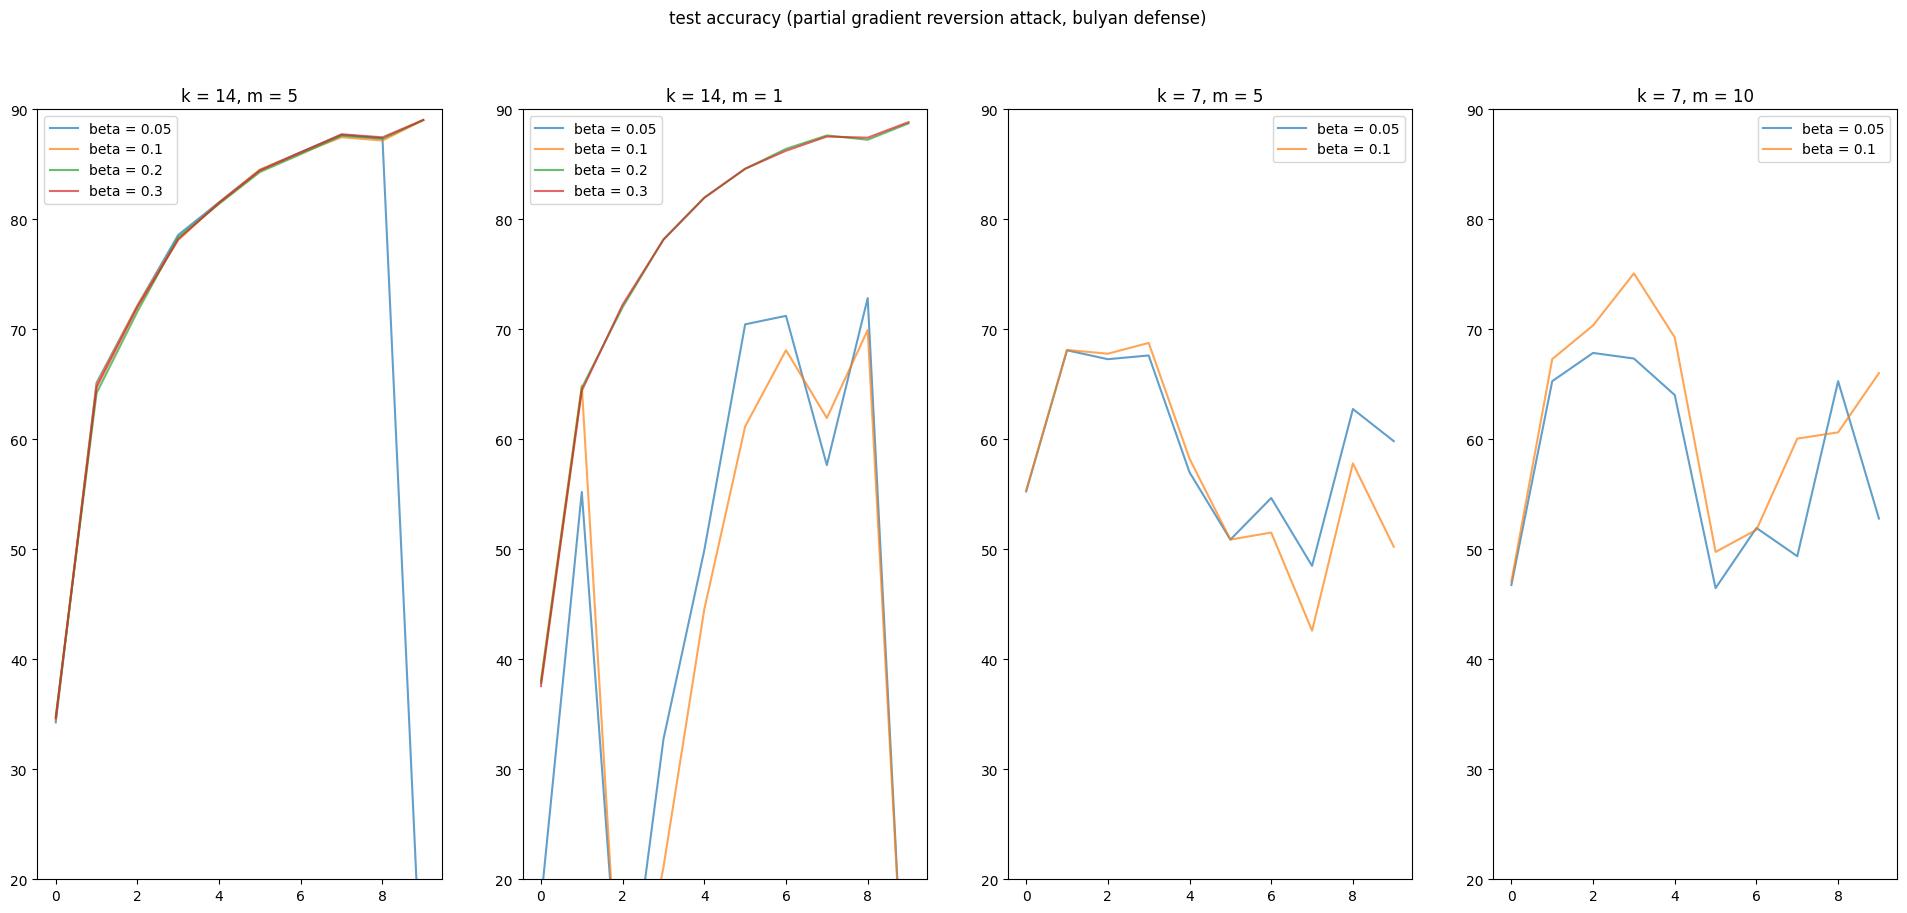

In [37]:
_plot_bulyan_results(results_bulyan_partial_reversion, "partial gradient reversion")

Partial gradient reversion differs from regular gradient reversion in that only parts of the gradient/update are inverted.
In the chosen naive implementation, we invert all layers up until a maximum number of components has been affected.
That is, we systematically only invert the few layers that we encounter first.
In a practical setting, it would be fair to assume that the inverted components are uniformly distributed across the update vector.

While we only invert parts of the gradient, we do so to a much larger extent.
Inverted components are multiplied by -1000 (compared to -5 for regular gradient reversion).

The stronger amplification of individual components is beneficial for both defense mechanisms, multi-krum and trimmed mean.
Trimmed-mean operates component-wise and can therefore easily identify strongly amplified components.
Unmodified components can safely be included in the aggregated update.
Multi-krum considers the distance between entire update tensors.
The strong amplification of select components ensures that those modifications remain observable at the level of the entire update tensor, even if it is to a smaller extent.

This explains why test accuracy remains largely unaffected for `k = 14, m = 5` and matches the accuracy that we observed for regular gradient reversion attacks.
A notable exception is the run with a beta value of 0.05.
There, multi-krum selects 2 malicious updates in the last iteration (and only in the last iteration).
Trimmed-mean can only eliminate one update per extreme (i.e., the minimum and maximum update).
If both updates are located at the same end of the spectrum, only one update is eliminated, which causes one update to take full effect.
The impact of this updates is drastic and cause test accuracy to drop by more than 60 percentage points.

A similar situation can be observed for beta values 0.05 and 0.1 in the setting with `k = 14, m = 1`.
As mentioned before, lower values for `m` increase the chance that multi-krum selects a malicious update.
This matches our observations, as multi-krum now often selects 2, and sometimes 3 or even 4 malicious updates.
This sincerely affects test accuracy of runs with lower beta values, as trimmed-mean is not able to eliminate the malicious updates in these settings.
For higher beta values, trimmed-mean successfully eliminates all malicious updates (more specifically: the inverted components of the malicious updates).

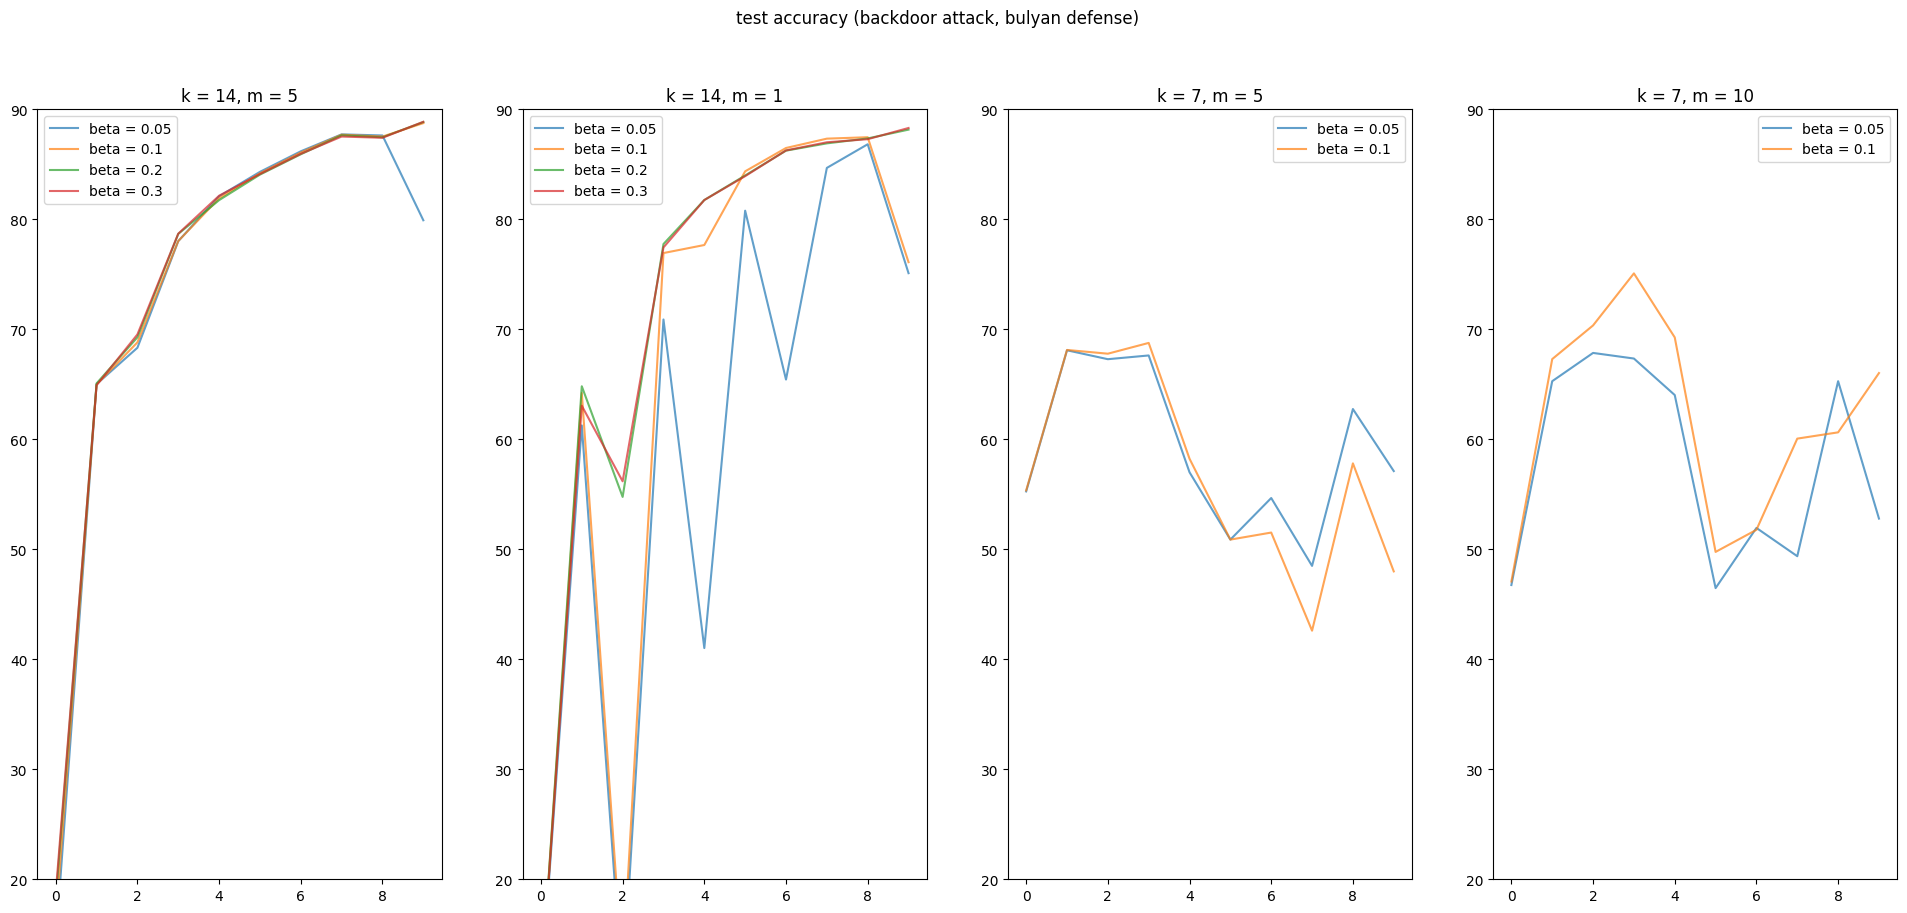

In [38]:
_plot_bulyan_results(results_bulyan, "backdoor")

Clients performing a backdoor attack modify a subset of their locally available dataset (here: half of all records) to include a pattern that sets off the backdoor.
The labels of modified records are adjusted accordingly.

For hyperparameters `k = 14, m = 5`, we observe that the presence of backdoor attacks only marginally affects the test accuracy attained at the end of training.
We note, however, that training progresses less rapidly than in other attack scenarios.
The fact that we observe a measurable impact on training performance indicates that the defense mechanism is not (fully) able to exclude malicious clients from training.

Unlike attack scenarios with partial gradient reversion attacks, participation of a single malicious client does not seem to have a catastrophic impact on overall test accuracy.
Yet, for our scenario with hyperparameters `k = 14, m = 5`, we still observe significantly more noise than we did for regular gradient inversion attacks.

It is noteworthy that for `k = 14`, we do not observe a single test run which test accuracy remained unaffected by the backdoor attack.

In [39]:
plot_table({
    "k": list(map(lambda it: it.krum_considered_update_count, variants_bulyan)),
    "m": list(map(lambda it: it.krum_max_malicious_update_count, variants_bulyan)),
    "beta": list(map(lambda it: it.mean_beta, variants_bulyan)),
    "success rate": list(map(lambda it: it.success_rate, results_backdoor_bulyan))
})

,k,m,beta,success rate
0,14,1,0.05,72.12
1,14,1,0.10,36.11
2,14,1,0.20,11.53
3,14,1,0.30,11.40
4,14,5,0.05,25.61
5,14,5,0.10,10.83
6,14,5,0.20,10.60
7,14,5,0.30,10.55
8,7,5,0.05,0.45
9,7,5,0.10,0.08


Unsurprisingly, the backdoor was least effective for configurations which test accuracy was only slightly impacted by the backdoor attack.
This strongly suggests that the configurations with stable test accuracy were indeed able to filter out malicious updates more effectively.

Configurations with `k = 7` obviously have the lowest attack success rates, as those configurations succeeded in filtering out all malicious updates.
The success rate of around 0.5 percent is simply due to the instability of the model's predictions.
The sensitivity to slight variations in the input could be reduced through data augmentation techniques.

Among the remaining hyperparameter configurations, we observe the lowest success rate for the highest parameter values.
Our results suggest that the use of higher values for `k`, `m`, and `beta` reduces the susceptibility for backdoor attacks (in the covered range of values).

## Question 3: Implementing SparseFed Defense (7 points)

In this exercise, you will implement the [SparseFed Defense](https://arxiv.org/abs/2112.06274). SparseFed Defense involves two main steps for each participating device during the training process:
1. **Clipping the gradient:** Each device clips its gradient to reduce the impact of potentially malicious updates.
2. **Aggregating top-k updates:** During the aggregation phase, only the gradients with the highest magnitudes (top-k) are considered. This method is designed to minimize the risk of model poisoning by excluding anomalous gradient contributions from potentially compromised devices.

### Scoring:
- _(2 points)_ Implement a simplified version of SparseFed based on the clipping code provided in the template notebook. Unlike the original algorithm which includes momentum, you only need to implement the clipping step and the sparsification step. However, ensure that only the top-k coordinates in the aggregated gradients are selected based on their magnitudes. For example, if the aggregated gradient is `[3, -1, -1, -3]`, selecting the top-2 by magnitude should result in `[3, 0, 0, -3]`.

- _(3 points)_ Evaluate the performance of your implemented SparseFed defense against two types of attacks: `AttackerGradientReversion` and `AttackerBackdoor`. Adjust the values of the defense hyperparameter k to optimize defense effectiveness. Ensure the data distribution remains i.i.d., and the attacker's hyperparameters are unchanged from the template. Document and compare the performance of SparseFed to the simple clipping defense across these attack scenarios. Suggested values for k include percentages of the total parameters, such as 20%, 50%, and 80%.

- _(2 points)_ Analyze and discuss the results to determine if SparseFed provided any improvements. Explain why the sparsefication either succeeded or failed in enhancing the model's robustness against the specified attacks. Include this analysis in your notebook.

In [40]:
def sparse_fed(
    all_updates: list[ClientUpdate], k: float, clip_norm_ratio: float = 1
) -> list[torch.Tensor]:
    clipped_parameters: list[torch.Tensor] = clipping(all_updates, clip_norm_ratio)

    def sparsify_parameter(parameter: torch.Tensor) -> torch.Tensor:
        parameter_shape = parameter.size()
        flattened_parameter = parameter.view(-1)

        retained_components_count = int(flattened_parameter.size(dim=0) * k)
        retained_components = torch.topk(flattened_parameter.abs(), k=retained_components_count)

        sparse_parameter = torch.zeros_like(flattened_parameter)
        sparse_parameter[retained_components.indices] = flattened_parameter[retained_components.indices]

        return sparse_parameter.view(*parameter_shape)

    return [sparsify_parameter(it) for it in clipped_parameters]

In [41]:
def run_training_clipping_sparse_fed(
    attack_type: typing.Literal["gradient-reversion", "backdoor"],
    defense_type: typing.Literal["clipping", "sparse-fed"],
    k: float,
) -> tuple[RunResult, BackdoorEvaluationResult]:
    dataset = split(nr_clients=100, iid=True, seed=42)

    match defense_type:
        case "clipping":
            defense = lambda all_updates: clipping(all_updates)
        case "sparse-fed":
            defense = lambda all_updates: sparse_fed(all_updates, k)

    server = configure_server(
        dataset,
        None,
        defense,
    )

    match attack_type:
        case "gradient-reversion":
            inject_malicious_clients(
                server, malicious_client_factory=build_gradient_reversion_client
            )
        case "backdoor":
            inject_malicious_clients(
                server, malicious_client_factory=build_backdoor_client
            )

    return server.run(10), evaluate_backdoor(server.model, test_loader)

In [42]:
variants_sparse_fed = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.9, 0.95]

In [43]:
result_clipping, result_backdoor_clipping = run_training_clipping_sparse_fed('backdoor', 'clipping', 0)

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


Rounds:   0%|          | 0/10 [00:00<?, ?it/s]

selected clients: [7, 8, 12, 17, 36, 45, 47, 49, 54, 61, 63, 68, 71, 73, 75, 83, 84, 86, 89, 94] (whereof 5 are malicious)


Rounds:  10%|█         | 1/10 [00:04<00:41,  4.62s/it]

selected clients: [4, 5, 13, 15, 18, 30, 34, 39, 44, 47, 51, 53, 58, 61, 62, 69, 70, 74, 79, 84] (whereof 2 are malicious)


Rounds:  20%|██        | 2/10 [00:12<00:52,  6.55s/it]

selected clients: [8, 13, 23, 28, 36, 37, 40, 45, 54, 61, 68, 69, 71, 75, 76, 78, 79, 86, 87, 97] (whereof 6 are malicious)


Rounds:  30%|███       | 3/10 [00:19<00:48,  6.91s/it]

selected clients: [7, 8, 9, 11, 20, 30, 36, 40, 50, 52, 53, 54, 56, 59, 60, 69, 75, 77, 85, 94] (whereof 5 are malicious)


Rounds:  40%|████      | 4/10 [00:26<00:41,  6.92s/it]

selected clients: [2, 8, 10, 15, 29, 31, 35, 37, 41, 45, 46, 57, 65, 68, 70, 73, 74, 84, 87, 94] (whereof 5 are malicious)


Rounds:  50%|█████     | 5/10 [00:33<00:34,  6.99s/it]

selected clients: [7, 9, 24, 25, 28, 31, 41, 43, 44, 62, 69, 70, 73, 77, 79, 81, 83, 90, 93, 99] (whereof 5 are malicious)


Rounds:  60%|██████    | 6/10 [00:42<00:30,  7.66s/it]

selected clients: [3, 7, 8, 12, 17, 18, 26, 32, 36, 39, 48, 51, 53, 55, 57, 58, 70, 74, 89, 93] (whereof 5 are malicious)


Rounds:  70%|███████   | 7/10 [00:51<00:24,  8.09s/it]

selected clients: [5, 7, 15, 24, 26, 34, 39, 40, 43, 44, 45, 52, 54, 60, 66, 77, 79, 87, 91, 95] (whereof 6 are malicious)


Rounds:  80%|████████  | 8/10 [01:03<00:18,  9.28s/it]

selected clients: [3, 9, 13, 20, 21, 22, 23, 28, 37, 54, 55, 62, 67, 81, 84, 85, 89, 90, 92, 98] (whereof 2 are malicious)


Rounds:  90%|█████████ | 9/10 [01:14<00:09,  9.68s/it]

selected clients: [2, 3, 8, 10, 13, 20, 24, 30, 33, 36, 45, 49, 66, 76, 77, 81, 83, 84, 90, 98] (whereof 7 are malicious)


In [44]:
results_sparse_fed: list[RunResult] = []
results_backdoor_sparse_fed: list[BackdoorEvaluationResult] = []

for variant in tqdm(variants_sparse_fed, "variant", leave=False):
    result, backdoor_result = run_training_clipping_sparse_fed('backdoor', 'sparse-fed', variant)

    results_sparse_fed.append(result)
    results_backdoor_sparse_fed.append(backdoor_result)

variant:   0%|          | 0/8 [00:00<?, ?it/s]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [7, 8, 12, 17, 36, 45, 47, 49, 54, 61, 63, 68, 71, 73, 75, 83, 84, 86, 89, 94] (whereof 5 are malicious)


selected clients: [4, 5, 13, 15, 18, 30, 34, 39, 44, 47, 51, 53, 58, 61, 62, 69, 70, 74, 79, 84] (whereof 2 are malicious)


selected clients: [8, 13, 23, 28, 36, 37, 40, 45, 54, 61, 68, 69, 71, 75, 76, 78, 79, 86, 87, 97] (whereof 6 are malicious)


selected clients: [7, 8, 9, 11, 20, 30, 36, 40, 50, 52, 53, 54, 56, 59, 60, 69, 75, 77, 85, 94] (whereof 5 are malicious)


selected clients: [2, 8, 10, 15, 29, 31, 35, 37, 41, 45, 46, 57, 65, 68, 70, 73, 74, 84, 87, 94] (whereof 5 are malicious)


selected clients: [7, 9, 24, 25, 28, 31, 41, 43, 44, 62, 69, 70, 73, 77, 79, 81, 83, 90, 93, 99] (whereof 5 are malicious)


selected clients: [3, 7, 8, 12, 17, 18, 26, 32, 36, 39, 48, 51, 53, 55, 57, 58, 70, 74, 89, 93] (whereof 5 are malicious)


selected clients: [5, 7, 15, 24, 26, 34, 39, 40, 43, 44, 45, 52, 54, 60, 66, 77, 79, 87, 91, 95] (whereof 6 are malicious)


selected clients: [3, 9, 13, 20, 21, 22, 23, 28, 37, 54, 55, 62, 67, 81, 84, 85, 89, 90, 92, 98] (whereof 2 are malicious)


selected clients: [2, 3, 8, 10, 13, 20, 24, 30, 33, 36, 45, 49, 66, 76, 77, 81, 83, 84, 90, 98] (whereof 7 are malicious)


variant:  12%|█▎        | 1/8 [01:30<10:33, 90.47s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [7, 8, 12, 17, 36, 45, 47, 49, 54, 61, 63, 68, 71, 73, 75, 83, 84, 86, 89, 94] (whereof 5 are malicious)


selected clients: [4, 5, 13, 15, 18, 30, 34, 39, 44, 47, 51, 53, 58, 61, 62, 69, 70, 74, 79, 84] (whereof 2 are malicious)


selected clients: [8, 13, 23, 28, 36, 37, 40, 45, 54, 61, 68, 69, 71, 75, 76, 78, 79, 86, 87, 97] (whereof 6 are malicious)


selected clients: [7, 8, 9, 11, 20, 30, 36, 40, 50, 52, 53, 54, 56, 59, 60, 69, 75, 77, 85, 94] (whereof 5 are malicious)


selected clients: [2, 8, 10, 15, 29, 31, 35, 37, 41, 45, 46, 57, 65, 68, 70, 73, 74, 84, 87, 94] (whereof 5 are malicious)


selected clients: [7, 9, 24, 25, 28, 31, 41, 43, 44, 62, 69, 70, 73, 77, 79, 81, 83, 90, 93, 99] (whereof 5 are malicious)


selected clients: [3, 7, 8, 12, 17, 18, 26, 32, 36, 39, 48, 51, 53, 55, 57, 58, 70, 74, 89, 93] (whereof 5 are malicious)


selected clients: [5, 7, 15, 24, 26, 34, 39, 40, 43, 44, 45, 52, 54, 60, 66, 77, 79, 87, 91, 95] (whereof 6 are malicious)


selected clients: [3, 9, 13, 20, 21, 22, 23, 28, 37, 54, 55, 62, 67, 81, 84, 85, 89, 90, 92, 98] (whereof 2 are malicious)


selected clients: [2, 3, 8, 10, 13, 20, 24, 30, 33, 36, 45, 49, 66, 76, 77, 81, 83, 84, 90, 98] (whereof 7 are malicious)


variant:  25%|██▌       | 2/8 [02:54<08:40, 86.72s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [7, 8, 12, 17, 36, 45, 47, 49, 54, 61, 63, 68, 71, 73, 75, 83, 84, 86, 89, 94] (whereof 5 are malicious)


selected clients: [4, 5, 13, 15, 18, 30, 34, 39, 44, 47, 51, 53, 58, 61, 62, 69, 70, 74, 79, 84] (whereof 2 are malicious)


selected clients: [8, 13, 23, 28, 36, 37, 40, 45, 54, 61, 68, 69, 71, 75, 76, 78, 79, 86, 87, 97] (whereof 6 are malicious)


selected clients: [7, 8, 9, 11, 20, 30, 36, 40, 50, 52, 53, 54, 56, 59, 60, 69, 75, 77, 85, 94] (whereof 5 are malicious)


selected clients: [2, 8, 10, 15, 29, 31, 35, 37, 41, 45, 46, 57, 65, 68, 70, 73, 74, 84, 87, 94] (whereof 5 are malicious)


selected clients: [7, 9, 24, 25, 28, 31, 41, 43, 44, 62, 69, 70, 73, 77, 79, 81, 83, 90, 93, 99] (whereof 5 are malicious)


selected clients: [3, 7, 8, 12, 17, 18, 26, 32, 36, 39, 48, 51, 53, 55, 57, 58, 70, 74, 89, 93] (whereof 5 are malicious)


selected clients: [5, 7, 15, 24, 26, 34, 39, 40, 43, 44, 45, 52, 54, 60, 66, 77, 79, 87, 91, 95] (whereof 6 are malicious)


selected clients: [3, 9, 13, 20, 21, 22, 23, 28, 37, 54, 55, 62, 67, 81, 84, 85, 89, 90, 92, 98] (whereof 2 are malicious)


selected clients: [2, 3, 8, 10, 13, 20, 24, 30, 33, 36, 45, 49, 66, 76, 77, 81, 83, 84, 90, 98] (whereof 7 are malicious)


variant:  38%|███▊      | 3/8 [04:22<07:16, 87.31s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [7, 8, 12, 17, 36, 45, 47, 49, 54, 61, 63, 68, 71, 73, 75, 83, 84, 86, 89, 94] (whereof 5 are malicious)


selected clients: [4, 5, 13, 15, 18, 30, 34, 39, 44, 47, 51, 53, 58, 61, 62, 69, 70, 74, 79, 84] (whereof 2 are malicious)


selected clients: [8, 13, 23, 28, 36, 37, 40, 45, 54, 61, 68, 69, 71, 75, 76, 78, 79, 86, 87, 97] (whereof 6 are malicious)


selected clients: [7, 8, 9, 11, 20, 30, 36, 40, 50, 52, 53, 54, 56, 59, 60, 69, 75, 77, 85, 94] (whereof 5 are malicious)


selected clients: [2, 8, 10, 15, 29, 31, 35, 37, 41, 45, 46, 57, 65, 68, 70, 73, 74, 84, 87, 94] (whereof 5 are malicious)


selected clients: [7, 9, 24, 25, 28, 31, 41, 43, 44, 62, 69, 70, 73, 77, 79, 81, 83, 90, 93, 99] (whereof 5 are malicious)


selected clients: [3, 7, 8, 12, 17, 18, 26, 32, 36, 39, 48, 51, 53, 55, 57, 58, 70, 74, 89, 93] (whereof 5 are malicious)


selected clients: [5, 7, 15, 24, 26, 34, 39, 40, 43, 44, 45, 52, 54, 60, 66, 77, 79, 87, 91, 95] (whereof 6 are malicious)


selected clients: [3, 9, 13, 20, 21, 22, 23, 28, 37, 54, 55, 62, 67, 81, 84, 85, 89, 90, 92, 98] (whereof 2 are malicious)


selected clients: [2, 3, 8, 10, 13, 20, 24, 30, 33, 36, 45, 49, 66, 76, 77, 81, 83, 84, 90, 98] (whereof 7 are malicious)


variant:  50%|█████     | 4/8 [05:50<05:50, 87.56s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [7, 8, 12, 17, 36, 45, 47, 49, 54, 61, 63, 68, 71, 73, 75, 83, 84, 86, 89, 94] (whereof 5 are malicious)


selected clients: [4, 5, 13, 15, 18, 30, 34, 39, 44, 47, 51, 53, 58, 61, 62, 69, 70, 74, 79, 84] (whereof 2 are malicious)


selected clients: [8, 13, 23, 28, 36, 37, 40, 45, 54, 61, 68, 69, 71, 75, 76, 78, 79, 86, 87, 97] (whereof 6 are malicious)


selected clients: [7, 8, 9, 11, 20, 30, 36, 40, 50, 52, 53, 54, 56, 59, 60, 69, 75, 77, 85, 94] (whereof 5 are malicious)


selected clients: [2, 8, 10, 15, 29, 31, 35, 37, 41, 45, 46, 57, 65, 68, 70, 73, 74, 84, 87, 94] (whereof 5 are malicious)


selected clients: [7, 9, 24, 25, 28, 31, 41, 43, 44, 62, 69, 70, 73, 77, 79, 81, 83, 90, 93, 99] (whereof 5 are malicious)


selected clients: [3, 7, 8, 12, 17, 18, 26, 32, 36, 39, 48, 51, 53, 55, 57, 58, 70, 74, 89, 93] (whereof 5 are malicious)


selected clients: [5, 7, 15, 24, 26, 34, 39, 40, 43, 44, 45, 52, 54, 60, 66, 77, 79, 87, 91, 95] (whereof 6 are malicious)


selected clients: [3, 9, 13, 20, 21, 22, 23, 28, 37, 54, 55, 62, 67, 81, 84, 85, 89, 90, 92, 98] (whereof 2 are malicious)


selected clients: [2, 3, 8, 10, 13, 20, 24, 30, 33, 36, 45, 49, 66, 76, 77, 81, 83, 84, 90, 98] (whereof 7 are malicious)


variant:  62%|██████▎   | 5/8 [07:17<04:22, 87.40s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [7, 8, 12, 17, 36, 45, 47, 49, 54, 61, 63, 68, 71, 73, 75, 83, 84, 86, 89, 94] (whereof 5 are malicious)


selected clients: [4, 5, 13, 15, 18, 30, 34, 39, 44, 47, 51, 53, 58, 61, 62, 69, 70, 74, 79, 84] (whereof 2 are malicious)


selected clients: [8, 13, 23, 28, 36, 37, 40, 45, 54, 61, 68, 69, 71, 75, 76, 78, 79, 86, 87, 97] (whereof 6 are malicious)


selected clients: [7, 8, 9, 11, 20, 30, 36, 40, 50, 52, 53, 54, 56, 59, 60, 69, 75, 77, 85, 94] (whereof 5 are malicious)


selected clients: [2, 8, 10, 15, 29, 31, 35, 37, 41, 45, 46, 57, 65, 68, 70, 73, 74, 84, 87, 94] (whereof 5 are malicious)


selected clients: [7, 9, 24, 25, 28, 31, 41, 43, 44, 62, 69, 70, 73, 77, 79, 81, 83, 90, 93, 99] (whereof 5 are malicious)


selected clients: [3, 7, 8, 12, 17, 18, 26, 32, 36, 39, 48, 51, 53, 55, 57, 58, 70, 74, 89, 93] (whereof 5 are malicious)


selected clients: [5, 7, 15, 24, 26, 34, 39, 40, 43, 44, 45, 52, 54, 60, 66, 77, 79, 87, 91, 95] (whereof 6 are malicious)


selected clients: [3, 9, 13, 20, 21, 22, 23, 28, 37, 54, 55, 62, 67, 81, 84, 85, 89, 90, 92, 98] (whereof 2 are malicious)


selected clients: [2, 3, 8, 10, 13, 20, 24, 30, 33, 36, 45, 49, 66, 76, 77, 81, 83, 84, 90, 98] (whereof 7 are malicious)


variant:  75%|███████▌  | 6/8 [08:43<02:53, 86.99s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [7, 8, 12, 17, 36, 45, 47, 49, 54, 61, 63, 68, 71, 73, 75, 83, 84, 86, 89, 94] (whereof 5 are malicious)


selected clients: [4, 5, 13, 15, 18, 30, 34, 39, 44, 47, 51, 53, 58, 61, 62, 69, 70, 74, 79, 84] (whereof 2 are malicious)


selected clients: [8, 13, 23, 28, 36, 37, 40, 45, 54, 61, 68, 69, 71, 75, 76, 78, 79, 86, 87, 97] (whereof 6 are malicious)


selected clients: [7, 8, 9, 11, 20, 30, 36, 40, 50, 52, 53, 54, 56, 59, 60, 69, 75, 77, 85, 94] (whereof 5 are malicious)


selected clients: [2, 8, 10, 15, 29, 31, 35, 37, 41, 45, 46, 57, 65, 68, 70, 73, 74, 84, 87, 94] (whereof 5 are malicious)


selected clients: [7, 9, 24, 25, 28, 31, 41, 43, 44, 62, 69, 70, 73, 77, 79, 81, 83, 90, 93, 99] (whereof 5 are malicious)


selected clients: [3, 7, 8, 12, 17, 18, 26, 32, 36, 39, 48, 51, 53, 55, 57, 58, 70, 74, 89, 93] (whereof 5 are malicious)


selected clients: [5, 7, 15, 24, 26, 34, 39, 40, 43, 44, 45, 52, 54, 60, 66, 77, 79, 87, 91, 95] (whereof 6 are malicious)


selected clients: [3, 9, 13, 20, 21, 22, 23, 28, 37, 54, 55, 62, 67, 81, 84, 85, 89, 90, 92, 98] (whereof 2 are malicious)


selected clients: [2, 3, 8, 10, 13, 20, 24, 30, 33, 36, 45, 49, 66, 76, 77, 81, 83, 84, 90, 98] (whereof 7 are malicious)


variant:  88%|████████▊ | 7/8 [10:11<01:27, 87.36s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [7, 8, 12, 17, 36, 45, 47, 49, 54, 61, 63, 68, 71, 73, 75, 83, 84, 86, 89, 94] (whereof 5 are malicious)


selected clients: [4, 5, 13, 15, 18, 30, 34, 39, 44, 47, 51, 53, 58, 61, 62, 69, 70, 74, 79, 84] (whereof 2 are malicious)


selected clients: [8, 13, 23, 28, 36, 37, 40, 45, 54, 61, 68, 69, 71, 75, 76, 78, 79, 86, 87, 97] (whereof 6 are malicious)


selected clients: [7, 8, 9, 11, 20, 30, 36, 40, 50, 52, 53, 54, 56, 59, 60, 69, 75, 77, 85, 94] (whereof 5 are malicious)


selected clients: [2, 8, 10, 15, 29, 31, 35, 37, 41, 45, 46, 57, 65, 68, 70, 73, 74, 84, 87, 94] (whereof 5 are malicious)


selected clients: [7, 9, 24, 25, 28, 31, 41, 43, 44, 62, 69, 70, 73, 77, 79, 81, 83, 90, 93, 99] (whereof 5 are malicious)


selected clients: [3, 7, 8, 12, 17, 18, 26, 32, 36, 39, 48, 51, 53, 55, 57, 58, 70, 74, 89, 93] (whereof 5 are malicious)


selected clients: [5, 7, 15, 24, 26, 34, 39, 40, 43, 44, 45, 52, 54, 60, 66, 77, 79, 87, 91, 95] (whereof 6 are malicious)


selected clients: [3, 9, 13, 20, 21, 22, 23, 28, 37, 54, 55, 62, 67, 81, 84, 85, 89, 90, 92, 98] (whereof 2 are malicious)


selected clients: [2, 3, 8, 10, 13, 20, 24, 30, 33, 36, 45, 49, 66, 76, 77, 81, 83, 84, 90, 98] (whereof 7 are malicious)


In [45]:
result_clipping_reversion, _ = run_training_clipping_sparse_fed('gradient-reversion', 'clipping', 0)

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


Rounds:   0%|          | 0/10 [00:00<?, ?it/s]

selected clients: [7, 8, 12, 17, 36, 45, 47, 49, 54, 61, 63, 68, 71, 73, 75, 83, 84, 86, 89, 94] (whereof 5 are malicious)


Rounds:  10%|█         | 1/10 [00:04<00:42,  4.72s/it]

selected clients: [4, 5, 13, 15, 18, 30, 34, 39, 44, 47, 51, 53, 58, 61, 62, 69, 70, 74, 79, 84] (whereof 2 are malicious)


Rounds:  20%|██        | 2/10 [00:12<00:54,  6.77s/it]

selected clients: [8, 13, 23, 28, 36, 37, 40, 45, 54, 61, 68, 69, 71, 75, 76, 78, 79, 86, 87, 97] (whereof 6 are malicious)


Rounds:  30%|███       | 3/10 [00:20<00:49,  7.03s/it]

selected clients: [7, 8, 9, 11, 20, 30, 36, 40, 50, 52, 53, 54, 56, 59, 60, 69, 75, 77, 85, 94] (whereof 5 are malicious)


Rounds:  40%|████      | 4/10 [00:27<00:42,  7.03s/it]

selected clients: [2, 8, 10, 15, 29, 31, 35, 37, 41, 45, 46, 57, 65, 68, 70, 73, 74, 84, 87, 94] (whereof 5 are malicious)


Rounds:  50%|█████     | 5/10 [00:34<00:35,  7.08s/it]

selected clients: [7, 9, 24, 25, 28, 31, 41, 43, 44, 62, 69, 70, 73, 77, 79, 81, 83, 90, 93, 99] (whereof 5 are malicious)


Rounds:  60%|██████    | 6/10 [00:42<00:30,  7.52s/it]

selected clients: [3, 7, 8, 12, 17, 18, 26, 32, 36, 39, 48, 51, 53, 55, 57, 58, 70, 74, 89, 93] (whereof 5 are malicious)


Rounds:  70%|███████   | 7/10 [00:50<00:22,  7.41s/it]

selected clients: [5, 7, 15, 24, 26, 34, 39, 40, 43, 44, 45, 52, 54, 60, 66, 77, 79, 87, 91, 95] (whereof 6 are malicious)


Rounds:  80%|████████  | 8/10 [00:57<00:14,  7.39s/it]

selected clients: [3, 9, 13, 20, 21, 22, 23, 28, 37, 54, 55, 62, 67, 81, 84, 85, 89, 90, 92, 98] (whereof 2 are malicious)


Rounds:  90%|█████████ | 9/10 [01:04<00:07,  7.25s/it]

selected clients: [2, 3, 8, 10, 13, 20, 24, 30, 33, 36, 45, 49, 66, 76, 77, 81, 83, 84, 90, 98] (whereof 7 are malicious)


In [46]:
results_sparse_fed_reversion: list[RunResult] = []

for variant in tqdm(variants_sparse_fed, "variant", leave=False):
    result, _ = run_training_clipping_sparse_fed('gradient-reversion', 'sparse-fed', variant)

    results_sparse_fed_reversion.append(result)

variant:   0%|          | 0/8 [00:00<?, ?it/s]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [7, 8, 12, 17, 36, 45, 47, 49, 54, 61, 63, 68, 71, 73, 75, 83, 84, 86, 89, 94] (whereof 5 are malicious)


selected clients: [4, 5, 13, 15, 18, 30, 34, 39, 44, 47, 51, 53, 58, 61, 62, 69, 70, 74, 79, 84] (whereof 2 are malicious)


selected clients: [8, 13, 23, 28, 36, 37, 40, 45, 54, 61, 68, 69, 71, 75, 76, 78, 79, 86, 87, 97] (whereof 6 are malicious)


selected clients: [7, 8, 9, 11, 20, 30, 36, 40, 50, 52, 53, 54, 56, 59, 60, 69, 75, 77, 85, 94] (whereof 5 are malicious)


selected clients: [2, 8, 10, 15, 29, 31, 35, 37, 41, 45, 46, 57, 65, 68, 70, 73, 74, 84, 87, 94] (whereof 5 are malicious)


selected clients: [7, 9, 24, 25, 28, 31, 41, 43, 44, 62, 69, 70, 73, 77, 79, 81, 83, 90, 93, 99] (whereof 5 are malicious)


selected clients: [3, 7, 8, 12, 17, 18, 26, 32, 36, 39, 48, 51, 53, 55, 57, 58, 70, 74, 89, 93] (whereof 5 are malicious)


selected clients: [5, 7, 15, 24, 26, 34, 39, 40, 43, 44, 45, 52, 54, 60, 66, 77, 79, 87, 91, 95] (whereof 6 are malicious)


selected clients: [3, 9, 13, 20, 21, 22, 23, 28, 37, 54, 55, 62, 67, 81, 84, 85, 89, 90, 92, 98] (whereof 2 are malicious)


selected clients: [2, 3, 8, 10, 13, 20, 24, 30, 33, 36, 45, 49, 66, 76, 77, 81, 83, 84, 90, 98] (whereof 7 are malicious)


variant:  12%|█▎        | 1/8 [01:26<10:05, 86.47s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [7, 8, 12, 17, 36, 45, 47, 49, 54, 61, 63, 68, 71, 73, 75, 83, 84, 86, 89, 94] (whereof 5 are malicious)


selected clients: [4, 5, 13, 15, 18, 30, 34, 39, 44, 47, 51, 53, 58, 61, 62, 69, 70, 74, 79, 84] (whereof 2 are malicious)


selected clients: [8, 13, 23, 28, 36, 37, 40, 45, 54, 61, 68, 69, 71, 75, 76, 78, 79, 86, 87, 97] (whereof 6 are malicious)


selected clients: [7, 8, 9, 11, 20, 30, 36, 40, 50, 52, 53, 54, 56, 59, 60, 69, 75, 77, 85, 94] (whereof 5 are malicious)


selected clients: [2, 8, 10, 15, 29, 31, 35, 37, 41, 45, 46, 57, 65, 68, 70, 73, 74, 84, 87, 94] (whereof 5 are malicious)


selected clients: [7, 9, 24, 25, 28, 31, 41, 43, 44, 62, 69, 70, 73, 77, 79, 81, 83, 90, 93, 99] (whereof 5 are malicious)


selected clients: [3, 7, 8, 12, 17, 18, 26, 32, 36, 39, 48, 51, 53, 55, 57, 58, 70, 74, 89, 93] (whereof 5 are malicious)


selected clients: [5, 7, 15, 24, 26, 34, 39, 40, 43, 44, 45, 52, 54, 60, 66, 77, 79, 87, 91, 95] (whereof 6 are malicious)


selected clients: [3, 9, 13, 20, 21, 22, 23, 28, 37, 54, 55, 62, 67, 81, 84, 85, 89, 90, 92, 98] (whereof 2 are malicious)


selected clients: [2, 3, 8, 10, 13, 20, 24, 30, 33, 36, 45, 49, 66, 76, 77, 81, 83, 84, 90, 98] (whereof 7 are malicious)


variant:  25%|██▌       | 2/8 [02:54<08:42, 87.13s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [7, 8, 12, 17, 36, 45, 47, 49, 54, 61, 63, 68, 71, 73, 75, 83, 84, 86, 89, 94] (whereof 5 are malicious)


selected clients: [4, 5, 13, 15, 18, 30, 34, 39, 44, 47, 51, 53, 58, 61, 62, 69, 70, 74, 79, 84] (whereof 2 are malicious)


selected clients: [8, 13, 23, 28, 36, 37, 40, 45, 54, 61, 68, 69, 71, 75, 76, 78, 79, 86, 87, 97] (whereof 6 are malicious)


selected clients: [7, 8, 9, 11, 20, 30, 36, 40, 50, 52, 53, 54, 56, 59, 60, 69, 75, 77, 85, 94] (whereof 5 are malicious)


selected clients: [2, 8, 10, 15, 29, 31, 35, 37, 41, 45, 46, 57, 65, 68, 70, 73, 74, 84, 87, 94] (whereof 5 are malicious)


selected clients: [7, 9, 24, 25, 28, 31, 41, 43, 44, 62, 69, 70, 73, 77, 79, 81, 83, 90, 93, 99] (whereof 5 are malicious)


selected clients: [3, 7, 8, 12, 17, 18, 26, 32, 36, 39, 48, 51, 53, 55, 57, 58, 70, 74, 89, 93] (whereof 5 are malicious)


selected clients: [5, 7, 15, 24, 26, 34, 39, 40, 43, 44, 45, 52, 54, 60, 66, 77, 79, 87, 91, 95] (whereof 6 are malicious)


selected clients: [3, 9, 13, 20, 21, 22, 23, 28, 37, 54, 55, 62, 67, 81, 84, 85, 89, 90, 92, 98] (whereof 2 are malicious)


selected clients: [2, 3, 8, 10, 13, 20, 24, 30, 33, 36, 45, 49, 66, 76, 77, 81, 83, 84, 90, 98] (whereof 7 are malicious)


variant:  38%|███▊      | 3/8 [04:17<07:07, 85.46s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [7, 8, 12, 17, 36, 45, 47, 49, 54, 61, 63, 68, 71, 73, 75, 83, 84, 86, 89, 94] (whereof 5 are malicious)


selected clients: [4, 5, 13, 15, 18, 30, 34, 39, 44, 47, 51, 53, 58, 61, 62, 69, 70, 74, 79, 84] (whereof 2 are malicious)


selected clients: [8, 13, 23, 28, 36, 37, 40, 45, 54, 61, 68, 69, 71, 75, 76, 78, 79, 86, 87, 97] (whereof 6 are malicious)


selected clients: [7, 8, 9, 11, 20, 30, 36, 40, 50, 52, 53, 54, 56, 59, 60, 69, 75, 77, 85, 94] (whereof 5 are malicious)


selected clients: [2, 8, 10, 15, 29, 31, 35, 37, 41, 45, 46, 57, 65, 68, 70, 73, 74, 84, 87, 94] (whereof 5 are malicious)


selected clients: [7, 9, 24, 25, 28, 31, 41, 43, 44, 62, 69, 70, 73, 77, 79, 81, 83, 90, 93, 99] (whereof 5 are malicious)


selected clients: [3, 7, 8, 12, 17, 18, 26, 32, 36, 39, 48, 51, 53, 55, 57, 58, 70, 74, 89, 93] (whereof 5 are malicious)


selected clients: [5, 7, 15, 24, 26, 34, 39, 40, 43, 44, 45, 52, 54, 60, 66, 77, 79, 87, 91, 95] (whereof 6 are malicious)


selected clients: [3, 9, 13, 20, 21, 22, 23, 28, 37, 54, 55, 62, 67, 81, 84, 85, 89, 90, 92, 98] (whereof 2 are malicious)


selected clients: [2, 3, 8, 10, 13, 20, 24, 30, 33, 36, 45, 49, 66, 76, 77, 81, 83, 84, 90, 98] (whereof 7 are malicious)


variant:  50%|█████     | 4/8 [05:43<05:42, 85.64s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [7, 8, 12, 17, 36, 45, 47, 49, 54, 61, 63, 68, 71, 73, 75, 83, 84, 86, 89, 94] (whereof 5 are malicious)


selected clients: [4, 5, 13, 15, 18, 30, 34, 39, 44, 47, 51, 53, 58, 61, 62, 69, 70, 74, 79, 84] (whereof 2 are malicious)


selected clients: [8, 13, 23, 28, 36, 37, 40, 45, 54, 61, 68, 69, 71, 75, 76, 78, 79, 86, 87, 97] (whereof 6 are malicious)


selected clients: [7, 8, 9, 11, 20, 30, 36, 40, 50, 52, 53, 54, 56, 59, 60, 69, 75, 77, 85, 94] (whereof 5 are malicious)


selected clients: [2, 8, 10, 15, 29, 31, 35, 37, 41, 45, 46, 57, 65, 68, 70, 73, 74, 84, 87, 94] (whereof 5 are malicious)


selected clients: [7, 9, 24, 25, 28, 31, 41, 43, 44, 62, 69, 70, 73, 77, 79, 81, 83, 90, 93, 99] (whereof 5 are malicious)


selected clients: [3, 7, 8, 12, 17, 18, 26, 32, 36, 39, 48, 51, 53, 55, 57, 58, 70, 74, 89, 93] (whereof 5 are malicious)


selected clients: [5, 7, 15, 24, 26, 34, 39, 40, 43, 44, 45, 52, 54, 60, 66, 77, 79, 87, 91, 95] (whereof 6 are malicious)


selected clients: [3, 9, 13, 20, 21, 22, 23, 28, 37, 54, 55, 62, 67, 81, 84, 85, 89, 90, 92, 98] (whereof 2 are malicious)


selected clients: [2, 3, 8, 10, 13, 20, 24, 30, 33, 36, 45, 49, 66, 76, 77, 81, 83, 84, 90, 98] (whereof 7 are malicious)


variant:  62%|██████▎   | 5/8 [07:13<04:22, 87.34s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [7, 8, 12, 17, 36, 45, 47, 49, 54, 61, 63, 68, 71, 73, 75, 83, 84, 86, 89, 94] (whereof 5 are malicious)


selected clients: [4, 5, 13, 15, 18, 30, 34, 39, 44, 47, 51, 53, 58, 61, 62, 69, 70, 74, 79, 84] (whereof 2 are malicious)


selected clients: [8, 13, 23, 28, 36, 37, 40, 45, 54, 61, 68, 69, 71, 75, 76, 78, 79, 86, 87, 97] (whereof 6 are malicious)


selected clients: [7, 8, 9, 11, 20, 30, 36, 40, 50, 52, 53, 54, 56, 59, 60, 69, 75, 77, 85, 94] (whereof 5 are malicious)


selected clients: [2, 8, 10, 15, 29, 31, 35, 37, 41, 45, 46, 57, 65, 68, 70, 73, 74, 84, 87, 94] (whereof 5 are malicious)


selected clients: [7, 9, 24, 25, 28, 31, 41, 43, 44, 62, 69, 70, 73, 77, 79, 81, 83, 90, 93, 99] (whereof 5 are malicious)


selected clients: [3, 7, 8, 12, 17, 18, 26, 32, 36, 39, 48, 51, 53, 55, 57, 58, 70, 74, 89, 93] (whereof 5 are malicious)


selected clients: [5, 7, 15, 24, 26, 34, 39, 40, 43, 44, 45, 52, 54, 60, 66, 77, 79, 87, 91, 95] (whereof 6 are malicious)


selected clients: [3, 9, 13, 20, 21, 22, 23, 28, 37, 54, 55, 62, 67, 81, 84, 85, 89, 90, 92, 98] (whereof 2 are malicious)


selected clients: [2, 3, 8, 10, 13, 20, 24, 30, 33, 36, 45, 49, 66, 76, 77, 81, 83, 84, 90, 98] (whereof 7 are malicious)


variant:  75%|███████▌  | 6/8 [08:42<02:55, 87.77s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [7, 8, 12, 17, 36, 45, 47, 49, 54, 61, 63, 68, 71, 73, 75, 83, 84, 86, 89, 94] (whereof 5 are malicious)


selected clients: [4, 5, 13, 15, 18, 30, 34, 39, 44, 47, 51, 53, 58, 61, 62, 69, 70, 74, 79, 84] (whereof 2 are malicious)


selected clients: [8, 13, 23, 28, 36, 37, 40, 45, 54, 61, 68, 69, 71, 75, 76, 78, 79, 86, 87, 97] (whereof 6 are malicious)


selected clients: [7, 8, 9, 11, 20, 30, 36, 40, 50, 52, 53, 54, 56, 59, 60, 69, 75, 77, 85, 94] (whereof 5 are malicious)


selected clients: [2, 8, 10, 15, 29, 31, 35, 37, 41, 45, 46, 57, 65, 68, 70, 73, 74, 84, 87, 94] (whereof 5 are malicious)


selected clients: [7, 9, 24, 25, 28, 31, 41, 43, 44, 62, 69, 70, 73, 77, 79, 81, 83, 90, 93, 99] (whereof 5 are malicious)


selected clients: [3, 7, 8, 12, 17, 18, 26, 32, 36, 39, 48, 51, 53, 55, 57, 58, 70, 74, 89, 93] (whereof 5 are malicious)


selected clients: [5, 7, 15, 24, 26, 34, 39, 40, 43, 44, 45, 52, 54, 60, 66, 77, 79, 87, 91, 95] (whereof 6 are malicious)


selected clients: [3, 9, 13, 20, 21, 22, 23, 28, 37, 54, 55, 62, 67, 81, 84, 85, 89, 90, 92, 98] (whereof 2 are malicious)


selected clients: [2, 3, 8, 10, 13, 20, 24, 30, 33, 36, 45, 49, 66, 76, 77, 81, 83, 84, 90, 98] (whereof 7 are malicious)


variant:  88%|████████▊ | 7/8 [10:09<01:27, 87.57s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [7, 8, 12, 17, 36, 45, 47, 49, 54, 61, 63, 68, 71, 73, 75, 83, 84, 86, 89, 94] (whereof 5 are malicious)


selected clients: [4, 5, 13, 15, 18, 30, 34, 39, 44, 47, 51, 53, 58, 61, 62, 69, 70, 74, 79, 84] (whereof 2 are malicious)


selected clients: [8, 13, 23, 28, 36, 37, 40, 45, 54, 61, 68, 69, 71, 75, 76, 78, 79, 86, 87, 97] (whereof 6 are malicious)


selected clients: [7, 8, 9, 11, 20, 30, 36, 40, 50, 52, 53, 54, 56, 59, 60, 69, 75, 77, 85, 94] (whereof 5 are malicious)


selected clients: [2, 8, 10, 15, 29, 31, 35, 37, 41, 45, 46, 57, 65, 68, 70, 73, 74, 84, 87, 94] (whereof 5 are malicious)


selected clients: [7, 9, 24, 25, 28, 31, 41, 43, 44, 62, 69, 70, 73, 77, 79, 81, 83, 90, 93, 99] (whereof 5 are malicious)


selected clients: [3, 7, 8, 12, 17, 18, 26, 32, 36, 39, 48, 51, 53, 55, 57, 58, 70, 74, 89, 93] (whereof 5 are malicious)


selected clients: [5, 7, 15, 24, 26, 34, 39, 40, 43, 44, 45, 52, 54, 60, 66, 77, 79, 87, 91, 95] (whereof 6 are malicious)


selected clients: [3, 9, 13, 20, 21, 22, 23, 28, 37, 54, 55, 62, 67, 81, 84, 85, 89, 90, 92, 98] (whereof 2 are malicious)


selected clients: [2, 3, 8, 10, 13, 20, 24, 30, 33, 36, 45, 49, 66, 76, 77, 81, 83, 84, 90, 98] (whereof 7 are malicious)


In [47]:
def _plot_clipping_sparse_fed(results_sparse_fed: list[RunResult], result_clipping: RunResult, attack_name: str):
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    fig.suptitle(f"test accuracy ({attack_name} attack)")

    for statistics, variant_parameter in zip(results_sparse_fed, variants_sparse_fed):
        axes.flatten()[0].plot(statistics.test_accuracy, label=f"k={variant_parameter}", alpha=0.7)

    axes.flatten()[0].plot(result_clipping.test_accuracy, label=f"<clipping>", alpha=0.7, linestyle='dashed')

    axes.flatten()[0].legend()
    axes.flatten()[0].title.set_text("SparseFed")

    axes.flatten()[1].plot(result_clipping.test_accuracy, label=f"<no parameters>", alpha=0.7)
    axes.flatten()[1].title.set_text("clipping")
    axes.flatten()[1].legend()

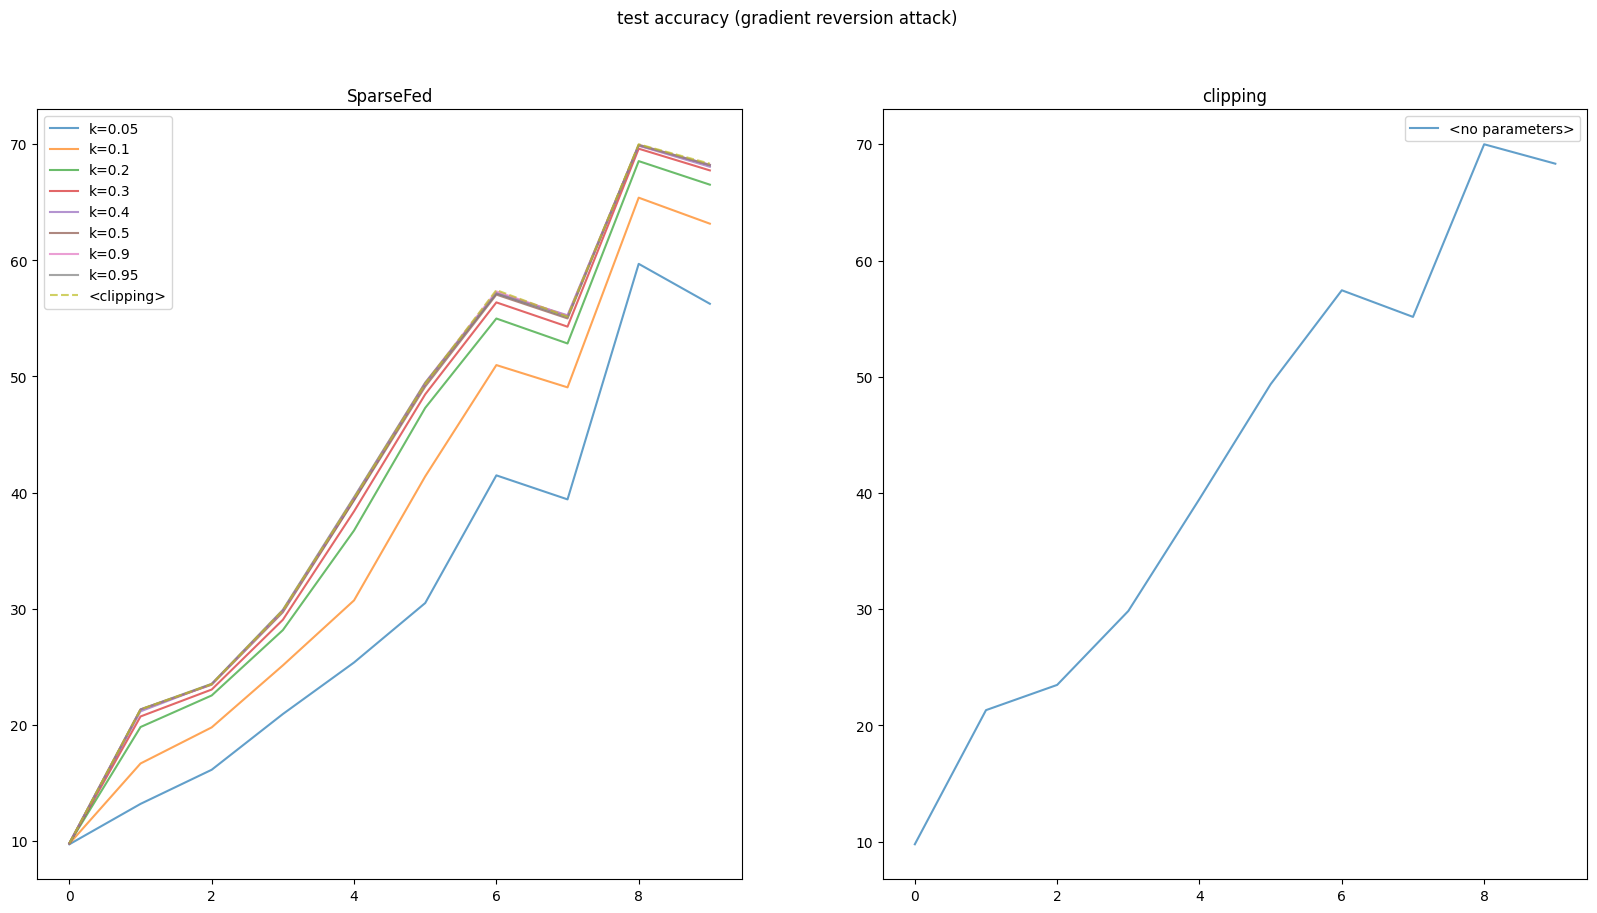

In [48]:
_plot_clipping_sparse_fed(results_sparse_fed_reversion, result_clipping_reversion, "gradient reversion")

SparseFed combines clipping with an additional sparsification step.
The sparseness parameter `k` in SparseFed specifies what proportion of components in the update tensor should be kept.
For instance, `k = 0.6` indicates that 60 percent of all components should be kept, or equivalently, that 40 percent of the update tensor should be discarded.
SparseFed selects the components to be kept based on their magnitude, whereby components with high magnitude go first.
To make the comparison in terms of magnitude more meaningful, SparseFed operates layer-wise (and not on the entire update tensor).

Clipping seems to be fairly effective against gradient reversion attacks.
The final test accuracy is about 10 percentage points lower than what we measured for our baseline run and other (properly parameterized) defense mechanisms.
Also, we note that the increase in test accuracy is slower in comparison.
Yet, the overall training progress is stable.
Clipping limits the magnitude of every update tensor, including malicious ones. 
The benign updates which nevertheless represent the majority of updates therefore alleviate the affects of malicious updates, without cancelling them out completely.

SparseFed does not provide an additional advantage over clipping.
Malicious clients performing gradient reversion attacks amplify all components, and therefore harm the quality of the aggregated update regardless of which components are subject to sparsification.
Removing parts of the update only further degrades the quality of the aggregated update.
This intuition matches our observation that less sparsification benefits test accuracy, with the performance of clipping being the maximal attainable performance.

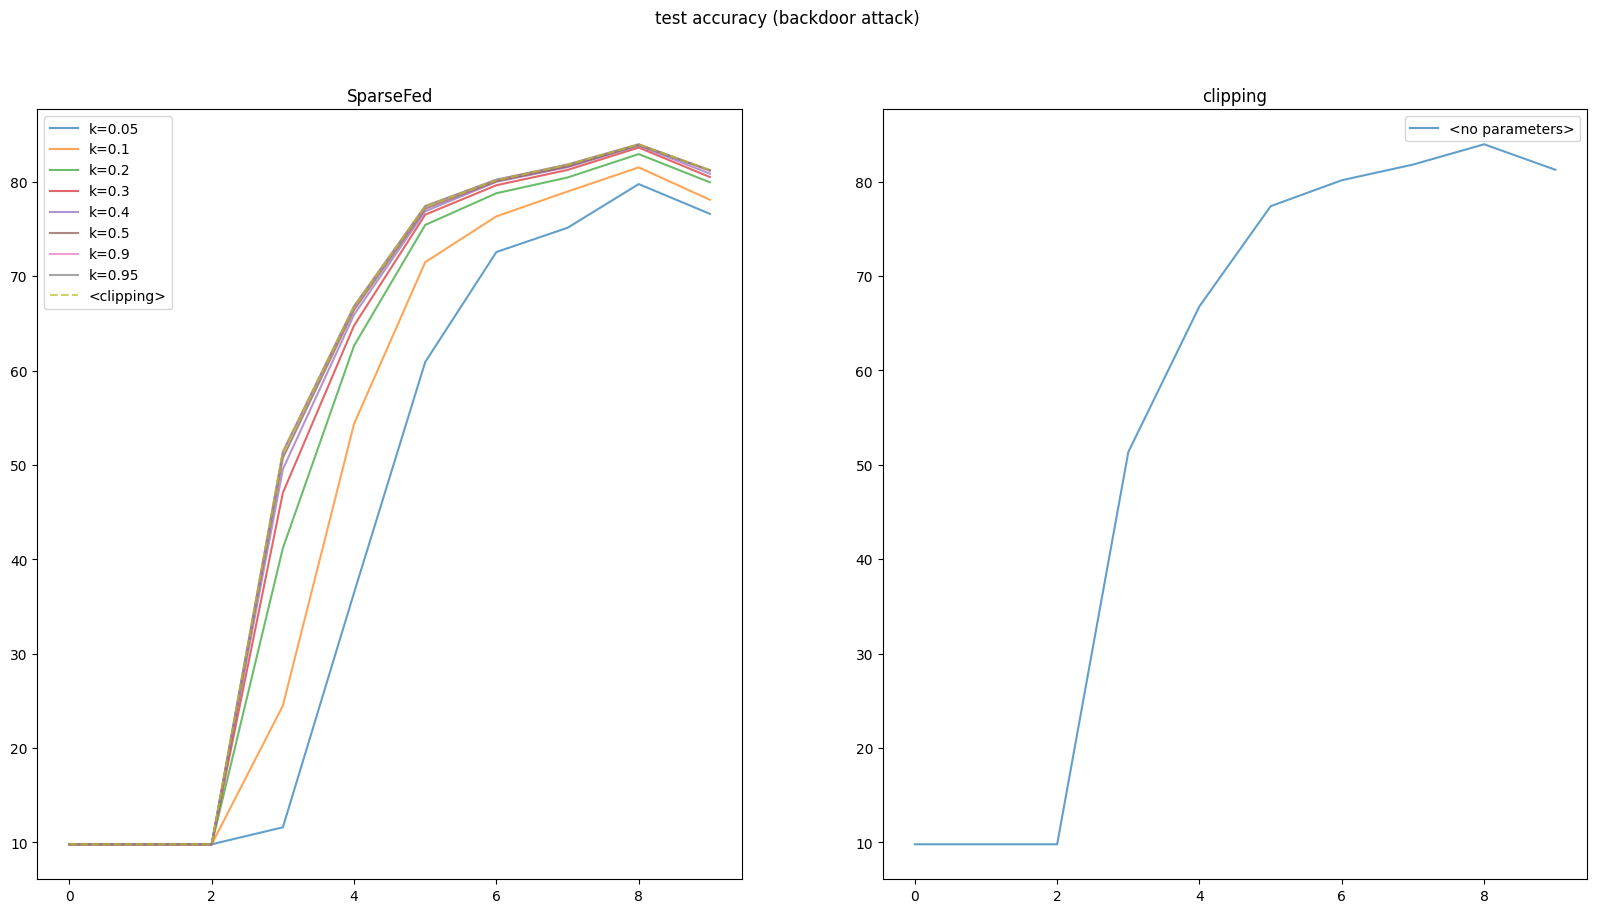

In [49]:
_plot_clipping_sparse_fed(results_sparse_fed, result_clipping, "backdoor")

Clients performing backdoor attacks also perform update amplification, but to a lesser extent than for gradient reversion attacks.
Components of the update tensor that would strongly benefit the attacker are therefore of high magnitude.
This translates to a high likelihood that those components are selected during the sparsification process.

The final test accuracy comes close to the test accuracy that we observed for our baseline.
We furthermore note that the test accuracy increases much more rapidly than it was the case for the gradient reversion attacks.
This can be explained by the fact that an update contributed by an attacker is not entirely malicious.
First, an attacker injects the backdoor pattern in only half of its samples.
The other half of its local dataset is unmodified, and therefore benign.
Second, the attacker is still interested in correctly identifying some pattern.
The difference consists in what output should be associated with that pattern.
This is arguably much more subtle than just jeopardizing training, and may yield updates that are much more similar to benign updates.

In [50]:
plot_table(
    {
        "k": variants_sparse_fed,
        "success rate": list(
            map(lambda it: it.success_rate, results_backdoor_sparse_fed)
        ),
    }
)

,k,success rate
0,0.05,75.77
1,0.10,78.34
2,0.20,81.36
3,0.30,83.38
4,0.40,84.45
5,0.50,84.84
6,0.90,85.09
7,0.95,85.22


In [51]:
print(f"success rate of backdoor attack with clipping: {result_backdoor_clipping.success_rate}")

success rate of backdoor attack with clipping: 85.06


As expected, clipping is widely ineffective against backdoor attacks.
We observe an attack success rate of 85 percent.
While clipping limits the impact of malicious updates, it is not able to prevent malicious clients to incorporate their updates altogether.

For SparseFed, we report lower attack success rates for lower values of `k`.
For `k = 0.05`, SparseFed is able to lower the attack success rate by almost 10 percentage points compared to clipping.
An attack success rate of 75 percent is still very high though.
Also, the reduction of 10 percentage points in attack success rate also comes with an equal reduction in test accuracy.
Therefore, one could argue that SparseFed did not defend against the backdoor attack at all but rather jeopardized the overall model performance.
In any case, we conclude that SparseFed is not an effective defense technique against backdoor attacks either.